Explanation.

Parameters:
        Column Name: string value of column from dataframe to which you wish to apply analysis
        breakpoints: list of percentage values to which you wish to break data
        
Returns:
        Dataframe show distribution amongst defined breakpoitns
        Prints a Bar Chart showing distribution for visual reviewa

## Create Functions to be Used throughout Analysis

In [1]:
def create_decile(df,
                  column_name,
                  breakpoints = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    '''
    Function created to understand distribution of Bankrupt companies throughout data. Using a decile analysis, breaking
    data into 10 equal components and determine break points for each threshold and what percentage of companies
    which are Bankrupt and Not Bankrupt appear in each.
    
    Utilizied as historgram for entire dataset did not show compelling results due to outliers and large variances in 
    distribution.
    
    Function calculates distribution over entire dataset and then seperates into 2, Bankrupt Companies and Non Bankrupct
    companies.
    
    ex. create_decile(df,'net profit / total assets') shows a Plot where Bankrupcies are heavily weighted towards
    instances in first 2 deciles, illustrating the negative correlation of this variable, support the fact that
    companies which have a low (or negative) profit relative to their asset base) are more likely to go bankrupt.
    
    
    Parameters:
        Column Name: string value of column from dataframe to which you wish to apply analysis
        breakpoints: list of percentage values to which you wish to break data
        
    Returns:
        Dataframe show distribution amongst defined breakpoitns
        Prints a Bar Chart showing distribution for visual reviewa
        
    
    
    '''
    
    
    decile_values = df[column_name].quantile(breakpoints)
    plt.hist([df[column_name][df['BANKRUPTCY_FLAG']==1],
              df[column_name][df['BANKRUPTCY_FLAG']==0]],
                 bins=decile_values, range=(-1, 1), alpha=0.5, label=['Bankrupt', 'Not Bankrupt'])
        
    plt.title(f"Decile Analysis: {column_name}")
    plt.xlabel(f"{column_name}")
    plt.ylabel('Observations')
    plt.legend()
    plt.show()
    
    return pd.DataFrame(decile_values).T.reset_index().rename(columns={'index':'Financial Ratio'})
    
def review_dataset_dict(df):
    
    '''
    Function Created to Review Dataset for purposes of EDA. Specifically as these are ratios, and through review
    there appeared to be a number of outliers, wanted to be able to simply and easily review not only distribution
    of data, but also simple statistical information about values in columns
    
    
    '''
    
    
    # Create Blank Dict to Store
    blank_dict = {}
    
    # Create Thresholds to Count
    bins = [-np.inf, -1, 0, 1, np.inf]
    labels = ['Value Less than -1%', 'Value between -1 to 0', 'Value Between 0 to 1', 'Value Greater than 1']
    thresh_df = pd.DataFrame()
    
    
    # Loop through columns
    for i in df.columns:
        
        # remove text created variables which crash Python
        if i in ['dataset']:
            pass
        
        temp_df = df[i].copy()
        
        blank_dict[i] = {'null_records':len(temp_df[temp_df.isnull()]),
                         'zero_records':len(temp_df[temp_df==0]),
                         'max_value':temp_df.max(),
                         'min_value':temp_df.min(),
                         'mean_value':temp_df.mean(),
                         'std_dev':temp_df.std(),
                         'positive_values':len(temp_df[temp_df>0]),
                         'negative_values':len(temp_df[temp_df<0])}
        
        record_count = pd.cut(df[i], bins=bins, labels=labels, right=False)
        
        thresh_df = pd.concat([thresh_df,pd.DataFrame(record_count.value_counts().values,index=record_count.value_counts().index,columns=[i]).T])
    
    final_df = pd.DataFrame(blank_dict.values(),index=blank_dict.keys())

    return final_df.merge(thresh_df,left_index=True,right_index=True).reset_index().rename(columns={'index':'Financial Ratio'})

def clean_string(string,remove_chars=['+','-',"(",")",'/','*']):
    
    '''
    Function to clean some of the punctuation which appears in Column Headers
    
    '''
    new_string = ""
    for char in string:
        if char not in remove_chars:
            new_string +=char
    return new_string

def create_heatmap(df,column_name='',corr_value=.1,figsize=(20,15)):
    
    sns.set(style='white')
    
    # View column with Abbreviated title or full. Abbreviated displays nicer.
    corr = df.corr()
    
    if len(column_name)!=0:
        corr = corr[[column_name]]
        corr = corr[abs(corr[column_name])>corr_value]
    
    mask= np.zeros_like(corr,dtype=bool)
    mask[np.triu_indices_from(mask)]=True
    f,ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.3,center=0,square=True,linewidths=.5)
    
    plt.title('Heat Map of Correlation')
    plt.show()
    
    
def create_column_inclusion_review(df,
                               columns,
                               column_type_df='',
                               decile_review_df=''):
    
    df = df[columns].copy()
    
    temp_df = review_dataset_dict(df)
    
    if len(column_type_df)!=0:
        temp_df = temp_df.merge(column_type_df,on='Financial Ratio',how='left')
    if len(decile_review_df)!=0:
        temp_df = temp_df.merge(decile_review_df,on='Financial Ratio',how='left')
    
    return temp_df


def variable_review(df,
                    column_name,
                    og_column,
                    column_inclusion_review_df,
                    corr_weight=.15):
        
    print(column_inclusion_review_df[column_inclusion_review_df['Financial Ratio']==column_name].T)
    print(f"\n")
    
    create_heatmap(df[og_columns],column_name)
    create_decile(df,column_name)
    
    print('Top 20 Records')
    print(df.sort_values(column_name)[[column_name,'BANKRUPTCY_FLAG']].tail(20))
    
    print('Bottom 20 Records')
    print(df.sort_values(column_name)[[column_name,'BANKRUPTCY_FLAG']].head(20))
    
    return df[df[column_name].isnull()].T

# Process for reviewing Non Tier 1 Elements.

def review_single_variable_manully(df,
                                   column_name,
                                   baseline_columns,
                                   column_inclusion_review_df,
                                   og_columns,
                                   export_to_excel=0):
        
    import datetime
    now = datetime.datetime.now()
    
    # Currently Included Columns for Simple Reference
    print("Columns Currently In Scope:")
    for included in baseline_columns:
        print(f"{included}\n")
    
    # EDA
    variable_review(df,column_name,og_columns,column_inclusion_review_df)    
    print(f"Number of Null Records with Bankrupcy Flag Yes: {df[df[column_name].isnull()]['BANKRUPTCY_FLAG'].sum()}")
    
    # Review Questions
    blank_or_remove = input('Remove Null Records/ Zero Null Records/ Exit Loop (remove/zero/exit)')
    include_in_model = input('Subjective Belief as to whether variable should be included in model (include/exclude)')
    negative_value = input('Remove, Zero or Leave Negative Values (remove/zero/ignore)')
    decision_logic = input('Please Provide Comment on Decision for Archival Reference')
        
    record_df =  pd.DataFrame([blank_or_remove.lower(),include_in_model.lower(),negative_value.lower(),decision_logic.lower(),now],index=['Null Record Approach','Baseline V2 Model Inclusion',"Negative Valuation",'Archival Decisioning','Extract Time'],columns=[column_name]).T.reset_index().rename(columns={'index':'Financial Ratio'})
    
    if export_to_excel==1:
        clean_column_name = clean_string(column_name,remove_chars=['+','-',"(",")",'/','*']).replace(" ","_")
        record_df.to_excel(f"manual_review/manual_review_{clean_column_name}_{now.strftime('%d%m%y%h%m%s')}.xlsx",index=False)
            
    return record_df

def read_files_in_folder(folder_location,file_type='*',import_df=0):
    
    files_ = os.listdir(folder_location)
    
    if file_type =='*':
        files_desired = files_.copy()
    else:
        files_desired = [x for x in files_ if x.find('xlsx')>-1]
        
    if import_df ==1:
        final_df = pd.DataFrame()
        if file_type =='xlsx':
            pd_read = pd.read_excel
        elif file_type =='csv':
            pd_read = pd.read_csv      
        else:
            print('Update Function')              
        for file in files_desired:
            final_df = pd.concat([final_df,pd_read(f"{folder_location}/{file}")])
            
        return final_df
         
    return files_desired


def apply_standard_scaler(df,return_df='y'):
    '''
    Apply Standard Scaler, creating distribution with Mean 0 and Standard Deviation 1
    
    If list_of_columns is blank, applied to entire DataFrame.
    
    Otherwise, include list of variables you wish to transform, will return DF with transformed variables
    
    '''    
    scaler = StandardScaler()
    scaler.fit(df)

    scaled_array = scaler.transform(df)

    if return_df == 'y':
        return pd.DataFrame(scaled_array,columns=[df.columns.values]),scaler

    return scaled_array,scaler

def apply_min_max_scaler(df,return_df='y'):
    '''
    Apply Min Max Scale, with 
    
    If list_of_columns is blank, applied to entire DataFrame.
    
    Otherwise, include list of variables you wish to transform, will return DF with transformed variables
    
    '''

    scaler = MinMaxScaler()
    scaler.fit(df)
    
    scaled_array = scaler.transform(df)

    if return_df == 'y':
        return pd.DataFrame(scaled_array,columns=[df.columns.values]),scaler

    return scaled_array,scaler
        
def text_manipulation(layer_list):
    '''
    Simple function to apply text manipulation to display layer size in Dataframe in single column
    '''
    str_layer = ""
    for layer in layer_list:
        str_layer +=str(layer)+' '
    return str_layer




def create_balanced_dataset(X,y,observations=0,column_name='BANKRUPTCY_FLAG'):
    
    '''
    Function to take observations and labels, combine them together and then select a even numher of random examples
    
    X - X_Test or X_Training
    y - y_test or y_training
    observation - Number of records from both Binary On and Binary Off Column
    column_name - Name of Binary Column to filter
    
    
    Used Default Value for purposes of reducing typing in code and given function created for Project Exclusively.
    
    '''
    
    # If length of observations is not defined, create a even 50/ 50 dataset
    if observations == 0:
        observations = y[column_name].sum()
        
    if observations>y[column_name].sum():
        observations = y[column_name].sum()
        
    temp_df = pd.concat([X,y],axis=1).copy()
    
    df1 = temp_df[temp_df[column_name]==1].sample(observations).copy()
    df2 = temp_df[temp_df[column_name]==0].sample(observations).copy()
    
    final_df = pd.concat([df1,df2])
    final_df = final_df.sample(frac=1)
    
    X = final_df.drop(column_name,axis=1)
    y = final_df[[column_name]]
    
    return X,y


def data_cleaning(df,
                  remove_records=0,
                  clean_records=0):
    
    new_df = df.copy()
   
    # Remove Data
    if remove_records==1:
        
        # There are 8 Instances of Profit / Assets NA. 7 Not Bankrupt, 1 Bankrupt. These 8 instances are all blanks amongst tier 1, remove. Low Risk to information loss        
        # Single Company with no entry, not a bankrupt company, company also has many other blanks. Low Risk of Information loss
        
        
        conditions = [new_df['net profit / total assets'].isnull(),
                     new_df['working capital'].isnull()]
                     
        values = ['Net Profit/ Total Assets is Null',
                  'Working capital is Null']
        
        new_df['remove_reason'] = np.select(conditions,values,"")
        
        print(new_df['remove_reason'].value_counts())
            
    
    if clean_records==1:
    # Ratio meant to capture the Profitability of Assets. If company does not make a profit then this ratio 
    # doesn't necessarily have the same negative implication. Curtail at 0.
        new_df['net profit / total assets'] = np.where(new_df['net profit / total assets']<0,0,new_df['net profit / total assets'])

    # total liabilities / total assets meant to capture the amount of debt relative to the value of company.
    # A negative ratio does not have meaninful interpretation. 
    
        new_df['total liabilities / total assets'] = np.where(new_df['total liabilities / total assets']<0,0,new_df['total liabilities / total assets'])
        
    # Ratio Meant to Capture the amount of assets which are readily available in the short term to pay debt.
    # A negative Ratio does not have a meaningul interpretation, 0 means the company has no money in the immediate to pay debt
        new_df['working capital / total assets'] = np.where(new_df['working capital / total assets']<0,0,new_df['working capital / total assets'])
        
    # Ratio meant to Capture what Percentage of Assets are financed by Retained Earnings (Versus Debt).
    # This ratio is slightly problematic, because Negative Retained Earnings is technically possible, which is 
    # a material warning sign, meaning the company is financed completely by Debt. Will Cap at 0, which implies 
    # that the company is financed 100% by debt, which is a accurate technical interpretation
        
        new_df['retained earnings / total assets'] = np.where(new_df['retained earnings / total assets']<0,0,new_df['retained earnings / total assets'])
        #new_df[''] = np.where(new_df['']<0,0,new_df[''])
        
    # Negative Logarithm implies a value of Assets between 0 and 1, which tantamounts to having no assets. 
    # equivalent of 0, given low frequency of examples, capping value at 0,
    
        new_df['logarithm of total assets'] = np.where(new_df['logarithm of total assets']<0,0,new_df['logarithm of total assets'])
        #new_df[''] = np.where(new_df['']<0,0,new_df[''])
        
    # Variance in Working Capital Material. Negative working Capital, similiar in meaning to no working capital, in 
    # that not having the ability to pay bill is very bad, and technically, negative assets and negative liabilties 
    # shouldn't exist, they should simply become the opposite, as such a negative assets is a liability, which 
    # reduces working capital, thus net negatives to 0.
    
    # also, given Huge variance, create a new variable, Logarithim in attempt to build importance of high number,
    # while keeping scale consistent.
        
        new_df['logarithim of working capital'] = np.where(new_df['working capital']<1,1,new_df['working capital'])
        new_df['logarithim of working capital'] = new_df['logarithim of working capital'].apply(lambda x:np.log(x))
    
    # Similar Logic, shouldn't be negative values, Higher more risky, removing 1 instance, which was a noted Bankrupt, although differences
    # to value is nominal.
    
        new_df['short-term liabilities / total assets'] = np.where(new_df['short-term liabilities / total assets']<0,0,new_df['short-term liabilities / total assets'])
 
    return new_df[new_df['remove_reason']==""],new_df


def create_binary_baseline_reference(df):
    
    df = df.copy()
    
    df['NOT_PROFITABLE'] = np.where(df['net profit / total assets']==0,1,0)
    df['NO_LIQUIDITY'] = np.where(df['logarithim of working capital']==0,1,0)
    df['LIABILITIES_GT_ASSETS'] = np.where(df['total liabilities / total assets']>1,1,0)
    df['NO_EQUITY'] = np.where(df['retained earnings / total assets']==0,1,0)
    df['ST_OBLIGATIONS_GT_TOTAL_ASSETS'] =np.where(df['short-term liabilities / total assets']>1,1,0)
    df['TOTAL_BINARY_FLAGS'] = df[['NOT_PROFITABLE','NO_LIQUIDITY','LIABILITIES_GT_ASSETS','NO_EQUITY','ST_OBLIGATIONS_GT_TOTAL_ASSETS']].sum(axis=1)
    
    df['TWO_BINARY_FLAGS'] = np.where(df['TOTAL_BINARY_FLAGS']==2,1,0)
    df['THREE_BINARY_FLAGS'] = np.where(df['TOTAL_BINARY_FLAGS']==3,1,0)
    df['FOUR_BINARY_FLAGS'] = np.where(df['TOTAL_BINARY_FLAGS']==4,1,0)
    df['FIVE_BINARY_FLAGS'] = np.where(df['TOTAL_BINARY_FLAGS']==5,1,0)
    
    df['NEVER_BANKRUPT'] = 0
    df['ALWAYS_BANKRUPT'] = 1
    
    return df


def define_model_parameters(model=0,
                             prediction_name='',
                             hidden_layer_sizes=[],
                             activation='',
                             optimizer='',
                             learning_rate=0,
                             metrics=[''],
                             batch_size=0,
                             num_epochs=0,
                             decision_boundary=0,
                             solver="",
                             max_iter=0,
                             n_neighbors=0):
    model_parameters = {
        'model':model,
        'prediction_name':prediction_name,
        'hidden_layer_sizes':hidden_layer_sizes,
        'activation':activation,
        'optimizer':optimizer,
        'learning_rate':learning_rate,
        'metrics':metrics,
        'batch_size':batch_size,
        'num_epochs':num_epochs,
        'decision_boundary':decision_boundary,
        'solver':solver,
        'max_iter':max_iter,
        'n_neighbors':n_neighbors}
    
    return model_parameters

def generate_baseline_analysis(df,
                               prediction_columns=""):

    if prediction_columns=="":
        prediction_columns=df.drop('BANKRUPTCY_FLAG',axis=1).columns.values.tolist()
    
    new_df=df.copy()
   
    results = pd.DataFrame()
    test_dict = {}
    
    for count,i in enumerate(prediction_columns):
        
        pred_name = f"Prediction {count}: {i}"
        
        test_dict[pred_name] = {'1) Predictions':len(new_df),
                                '2) Bankrupties Predicted':len(new_df[new_df[i]==1]),
                                '3) True Positives':len(new_df[(new_df[i]==1)*(new_df['BANKRUPTCY_FLAG']==1)]),
                                '4) True Negatives':len(new_df[(new_df[i]==0)*(new_df['BANKRUPTCY_FLAG']==0)]),
                                '5) False Positives':len(new_df[(new_df[i]==1)*(new_df['BANKRUPTCY_FLAG']==0)]),
                                "6) False Negatives":len(new_df[(new_df[i]==0)*(new_df['BANKRUPTCY_FLAG']==1)])}
        try:
            test_dict[pred_name]['7) Precision']=test_dict[pred_name]['3) True Positives']/(test_dict[pred_name]['3) True Positives']+test_dict[pred_name]['4) True Negatives'])
        except:
            test_dict[pred_name]['7) Precision']=0
        
        try:
            test_dict[pred_name]['8) Recall']=test_dict[pred_name]['3) True Positives']/(test_dict[pred_name]['3) True Positives']+test_dict[pred_name]['5) False Positives'])
        except:
            test_dict[pred_name]['8) Recall']=0
        try:
            test_dict[pred_name]['9) Accuracy']=(test_dict[pred_name]['3) True Positives']+test_dict[pred_name]['4) True Negatives'])/len(df)
        except:
            test_dict[pred_name]['9) Accuracy']=0
  
    return pd.DataFrame(test_dict)


def create_df_models_to_test(list_of_model_parameters):
    final_df = pd.DataFrame()

    for model in list_of_model_parameters:
        temp_list = list(product(*model.values()))
        final_df = pd.concat([final_df,pd.DataFrame(temp_list,columns=model.keys())])

    final_df = final_df.reset_index(drop=True).fillna('')

    final_df['count']  =  final_df.groupby('model').cumcount() + 1
    final_df['count']= final_df['count'].apply(lambda x:str(x))
    final_df['prediction_name']  =  final_df['model'] + final_df['count']
    return final_df.drop('count',axis=1)
            

# def generate_baseline_analysis(df,
#                                prediction_columns
#                                ,prediction_rationale):
    
#     df=df.copy()
#     new_df = df.set_index('BANKRUPTCY_FLAG')[prediction_columns].reset_index()
    
#     results = pd.DataFrame()
#     test_dict = {}
    
#     for count,i in enumerate(prediction_columns):
        
#         pred_name = f"Prediction {count}: {i}"
        
#         test_dict[pred_name] = {'1) Bankrupties Predicted':len(new_df[new_df[i]==1]),
#                                 '2) True Positives':len(new_df[(new_df[i]==1)*(new_df['BANKRUPTCY_FLAG']==1)]),
#                                 '3) True Negatives':len(new_df[(new_df[i]==0)*(new_df['BANKRUPTCY_FLAG']==0)]),
#                                 '4) False Positives':len(new_df[(new_df[i]==1)*(new_df['BANKRUPTCY_FLAG']==0)]),
#                                 "5) False Negatives":len(new_df[(new_df[i]==0)*(new_df['BANKRUPTCY_FLAG']==1)])}
#         try:
#             test_dict[pred_name]['6) Precision']=test_dict[pred_name]['2) True Positives']/(test_dict[pred_name]['2) True Positives']+test_dict[pred_name]['3) True Negatives'])
#         except:
#             test_dict[pred_name]['6) Precision']=0
        
#         try:
#             test_dict[pred_name]['7) Recall']=test_dict[pred_name]['2) True Positives']/(test_dict[pred_name]['2) True Positives']+test_dict[pred_name]['4) False Positives'])
#         except:
#             test_dict[pred_name]['7) Recall']=0
#         try:
#             test_dict[pred_name]['8) Accuracy']=(test_dict[pred_name]['2) True Positives']+test_dict[pred_name]['3) True Negatives'])/len(df)
#         except:
#             test_dict[pred_name]['8) Accuracy']=0
  
#     return pd.DataFrame(test_dict)



# def generate_model(X,
#                    y,
#                    ml_model,
#                    dataset_str_definition,
#                    scaling,
#                    learning_rate,
#                    optimizer,
#                    activation,
#                    batch_size,
#                    epochs,
#                    validation_split,
#                    bankrupcy_observations,
#                    metrics,
#                    network_hidden_dimensions=[8,16,32],
#                    verbose=0):
    
    
#     '''
#     X - X_test Data Set
#     y - Data set labels
#     ml_model(neural_network,___,____) - Type of ML Model to Applied
#     scaling (None, min_max,standard_scalar) - To Determine what type of scaling to use on Dataset
#     metrics = 
#     learning_rate - Learning rate of Model
#     optimizer ('sgd','adam') - Optimization Model Utilized
#     loss_function - Loss Function applied to model
#     network_hidden_dimensions - number of layers and nodes per layer to be added to model (default is to add 3 hidden layers of 8,16,32 nodes)
#     batch_size - batch size of training (default 1000, if data set is less than 1000 it will maximize to size of data)
#     epochs - number of iterations to run through testing (defaul 20)
#     validation_splilt - percentage of test data to include in validation set (default 30%)
#     bankrupcy_observations ('entire_dataset','all_bankrupcies',n) - Number of Bankrupt Observations
    
#     '''
    
#     # Given our current dataset is not evenly distributed, we must give consideration to how to appropriately select
#     # our Dataset below partions the dataset
    
#     if bankrupcy_observations == 'entire_dataset':
#         pass
#     elif bankrupcy_observations == 'all_bankrupcies':
#         X,y = create_balanced_dataset(X,y)
#     else:
#         X,y = create_balanced_dataset(X,y,bankrupcy_observations)
    
#     print(len(X))
#     print(len(y))
    
#     # Apply Scaling to DataFrame After Trimming Dataset
#     if scaling.lower() == 'standard_scalar':
#         X = apply_standard_scaler(X,X.columns.values)
#     elif scaling.lower()=='min_max':
#         X = apply_min_max_scaler(X,X.columns.values)
        
#     if ml_model=='neural_network':
#         history,model = train_model(X=X,
#                                     y=y,
#                                     input_dim=len(X.columns),
#                                     metrics=metrics,
#                                     hidden_layer_sizes=network_hidden_dimensions,
#                                     activation=activation, 
#                                     optimizer=optimizer,
#                                     learning_rate=learning_rate,
#                                     batch_size=batch_size,
#                                     num_epochs=epochs,
#                                     validation_split=validation_split,
#                                     verbose=verbose)
        
#         model_results_df = pd.DataFrame(history.history)
#         model_results_df['Dataset'] = dataset_str_definition
#         model_results_df['Model'] = ml_model
#         model_results_df['activation'] = activation
#         model_results_df['optimizer'] = optimizer
#         model_results_df['learning_rate'] = learning_rate
#         model_results_df['batch_size'] = batch_size
#         model_results_df['epochs'] = epochs
#         model_results_df['validation_split'] = validation_split
#         model_results_df['hidden_layer_sizes'] = text_manipulation(network_hidden_dimensions)
#         model_results_df['bankrupt_observations'] = bankrupcy_observations
#         model_results_df['total_observations_read'] = len(X)
    
#     elif ml_model=='gradient_descent':
#         pass
#     elif ml_model=='decision_tree':
#         pass
#     elif ml_model=='knn':
#         pass
    
#     return history,model,model_results_df,model_results_df.tail(1)


In [2]:
# Create Dictionary to Track Progress and serve as reference throughout workbook

project_reference_dictionary = {'Goal':'The goal of our project is to determine whether we can create a model which predicts whether a company will go Bankrupt based on their reported Financial Ratio.',
                                'Step 1. Import Data':'Pending',
                                'Step 2. Review Data':'Pending',
                                'Step 3. Clean Data':'Pending',
                                'Step 4. Determine which Data to Include':'Pending',
                                'Step 5. Identify a Baseline':'Pending',
                                'Step 6. Generate Perspective Models':'Pending',
                                'Step 7. Compare Models':'Pending',
                                'Step 8. Tune Models':'Pending',
                                'Step 9. Select Model':'Pending',
                                'Step 10. Validate Against Test Data Set':'Pending',
                                'Step 11. Complete NeurIPS Checklist':'Pending'}

project_reference_dictionary['additional_items'] = ['How does company Size Impact',
                                                    'How does company Industry Impact',
                                                   'How is the amount of debt being given consideration',
                                                   'Can we demonstrate how this model would save money']

### Data Source

##### https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data

## Import Libraries

In [3]:
import os
import math
import sys
import seaborn as sns
from itertools import product
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tensorflow import keras
from tensorflow.keras import layers

pd.set_option('display.float_format', '{:.2f}'.format)

## Import Data 


In [4]:

# Create a Dataframe of all information, named df which we will populate the information imported from Excel into
df = pd.DataFrame()

# Read Annual Files downloaded from https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data
for i in [x for x in os.listdir() if x.find('.arff')!=-1]:
    temp_df = pd.DataFrame(arff.loadarff(i)[0])
    temp_df['dataset']=i
    df = pd.concat([df,temp_df])

# Change Column Header Names to respective Financial Ratio to ease Understanding and Interpretation, Excel Manually Compiled from Read Me on Website.
column_data = pd.read_excel('polish_company_data.xlsx')
column_data['COLUMN_NAME'] = column_data['COLUMN_NAME'].apply(lambda x:x.replace('X','Attr'))
column_data.loc[64,'COLUMN_NAME']='class'
column_data.loc[64,'FINANCIAL_RATIO']='BANKRUPTCY_FLAG'

df = df.rename(columns={column_data['COLUMN_NAME'].tolist()[x]:column_data['FINANCIAL_RATIO'].tolist()[x] for x in range(len(column_data['COLUMN_NAME']))})

# Convert Bankruptcy Flag into INT.
df['BANKRUPTCY_FLAG'] = df['BANKRUPTCY_FLAG'].apply(lambda x:int(x))

# Create a list of original column names, supports visualizations utilized below
og_columns = [x for x in df.columns if x not in ['dataset']]
og_predict_columns = og_columns.copy()
og_predict_columns.remove('BANKRUPTCY_FLAG')

train_df, test_df  = train_test_split(df, test_size=0.3, random_state=15)

# Update Dictionary
project_reference_dictionary['Step 1. Import Data'] = "Completed"


## Initial Data Review

In [5]:
# Using Function Created and defined above, create statistical summary analysis at variable level to provide 
# insight into the individual Ratios included

column_inclusion_review_df = create_column_inclusion_review(df,og_columns)
column_inclusion_review_df

Financial Ratio  null_records  \
0                           net profit / total assets             8   
1                    total liabilities / total assets             8   
2                      working capital / total assets             8   
3             current assets / short-term liabilities           134   
4   [(cash + short-term securities + receivables -...            89   
..                                                ...           ...   
60                                sales / receivables           102   
61              (short-term liabilities *365) / sales           127   
62                     sales / short-term liabilities           134   
63                               sales / fixed assets           812   
64                                    BANKRUPTCY_FLAG             0   

    zero_records   max_value    min_value  mean_value   std_dev  \
0            240       94.28      -463.89        0.04      2.99   
1             89      480.96      -430.87        0.59      5.84   
2             24       28.34      -479.96        0.11      5.44   
3              2    53433.00        -0.40        6.31    295.43   
4             43  1250100.00 -11903000.00     -385.35  61243.03   
..           ...         ...          ...         ...       ...   
60           122   108000.00       -12.66       17.03    553.05   
61           121 25016000.00  -2336500.00     1502.33 139266.70   
62           118    23454.00        -1.54        9.34    124.18   
63            88   294770.00    -10677.00       72.79   2369.34   
64         41314        1.00         0.00        0.05      0.21   

    positive_values  negative_values  Value Between 0 to 1  \
0             33865             9292                 33999   
1             43305                3                 41116   
2             33804             9569                 33797   
3             43267                2                  9569   
4             21356            21917                   319   
..              ...              ...                   ...   
60            43175                6                   670   
61            43153                4                   157   
62            43149                4                  1539   
63            42500                5                  3437   
64             2091                0                 41314   

    Value between -1 to 0  Value Less than -1%  Value Greater than 1  
0                    9106                  186                   106  
1                       0                    3                  2278  
2                    9134                  435                    31  
3                       2                    0                 33700  
4                     254                21663                 21080  
..                    ...                  ...                   ...  
60                      4                    2                 42627  
61                      0                    4                 43117  
62                      3                    1                 41728  
63                      3                    2                 39151  
64                      0                    0                  2091  

[65 rows x 13 columns]

### Identify Words in Colums to Determine potential Similarity

In [6]:
# Create a Dictionary of Words from Column Name to see what type of data we have available.
# First Review Identified a number of undesired Strings, created function to Clean.

column_data['CLEAN'] = column_data['FINANCIAL_RATIO'].apply(lambda x:clean_string(x))

# Count Occurances of Every Word in Column

word_dictionary = {}

for i in column_data['CLEAN']:
    word = i.split()
    for i in word:
        try:
            word_dictionary[i] +=1
        except:
            word_dictionary[i] =1
            
wd_df = pd.DataFrame(word_dictionary.values(),index=word_dictionary.keys(),columns=['word_count'])
wd_df.sort_values('word_count',ascending=False).head(15)

word_count
total                 33
assets                30
sales                 25
liabilities           24
profit                23
shortterm             12
gross                 11
operating              9
depreciation           8
365                    8
inventory              8
on                     8
current                7
activities             6
of                     6

### Incorporate Ratio Classification Review

In [7]:
# Applying knowledge of financial ratios, inconjuction with the above words, can we classify the type of ratio 
# consistently such that we can potentially avoid duplication and structural model problems via unitended duplication



# Using Words above, define each ratio based on name as either a Liquidity, Profitability, Capitalization or Turnover Ratio

column_type_df = pd.DataFrame(df.columns,columns=['Financial Ratio'])

condition = [column_type_df['Financial Ratio'].str.contains('working capital'),
             column_type_df['Financial Ratio'].str.contains('profit|EBIT|expenses|cost of'),
             column_type_df['Financial Ratio'].str.contains('assets|equity|retained|capital'),
             column_type_df['Financial Ratio'].str.contains('sales|receivables|inventory'),
             column_type_df['Financial Ratio'].str.contains('BANKRUPTCY_FLAG'),
            ]

values = ['Liqudity Ratio',
          'Profitability Ratio',
          'Capitalization Ratio',
          'Turnover Ratio',
          'Target Variable']

column_type_df['Ratio Classification'] = np.select(condition,values,'Other')

column_inclusion_review_df = create_column_inclusion_review(df,
                                                            og_columns,
                                                            column_type_df)

# Placing control in the case that additional Columns are Added or somehow changed

if len(column_inclusion_review_df[column_inclusion_review_df['Ratio Classification']=='Other'])>0:
    print('Please Review Data, Column is Missing Definition')
    sys.exit()

column_inclusion_review_df

Financial Ratio  null_records  \
0                           net profit / total assets             8   
1                    total liabilities / total assets             8   
2                      working capital / total assets             8   
3             current assets / short-term liabilities           134   
4   [(cash + short-term securities + receivables -...            89   
..                                                ...           ...   
60                                sales / receivables           102   
61              (short-term liabilities *365) / sales           127   
62                     sales / short-term liabilities           134   
63                               sales / fixed assets           812   
64                                    BANKRUPTCY_FLAG             0   

    zero_records   max_value    min_value  mean_value   std_dev  \
0            240       94.28      -463.89        0.04      2.99   
1             89      480.96      -430.87        0.59      5.84   
2             24       28.34      -479.96        0.11      5.44   
3              2    53433.00        -0.40        6.31    295.43   
4             43  1250100.00 -11903000.00     -385.35  61243.03   
..           ...         ...          ...         ...       ...   
60           122   108000.00       -12.66       17.03    553.05   
61           121 25016000.00  -2336500.00     1502.33 139266.70   
62           118    23454.00        -1.54        9.34    124.18   
63            88   294770.00    -10677.00       72.79   2369.34   
64         41314        1.00         0.00        0.05      0.21   

    positive_values  negative_values  Value Between 0 to 1  \
0             33865             9292                 33999   
1             43305                3                 41116   
2             33804             9569                 33797   
3             43267                2                  9569   
4             21356            21917                   319   
..              ...              ...                   ...   
60            43175                6                   670   
61            43153                4                   157   
62            43149                4                  1539   
63            42500                5                  3437   
64             2091                0                 41314   

    Value between -1 to 0  Value Less than -1%  Value Greater than 1  \
0                    9106                  186                   106   
1                       0                    3                  2278   
2                    9134                  435                    31   
3                       2                    0                 33700   
4                     254                21663                 21080   
..                    ...                  ...                   ...   
60                      4                    2                 42627   
61                      0                    4                 43117   
62                      3                    1                 41728   
63                      3                    2                 39151   
64                      0                    0                  2091   

    Ratio Classification  
0    Profitability Ratio  
1   Capitalization Ratio  
2         Liqudity Ratio  
3   Capitalization Ratio  
4    Profitability Ratio  
..                   ...  
60        Turnover Ratio  
61        Turnover Ratio  
62        Turnover Ratio  
63  Capitalization Ratio  
64       Target Variable  

[65 rows x 14 columns]

### Visual Review of Data

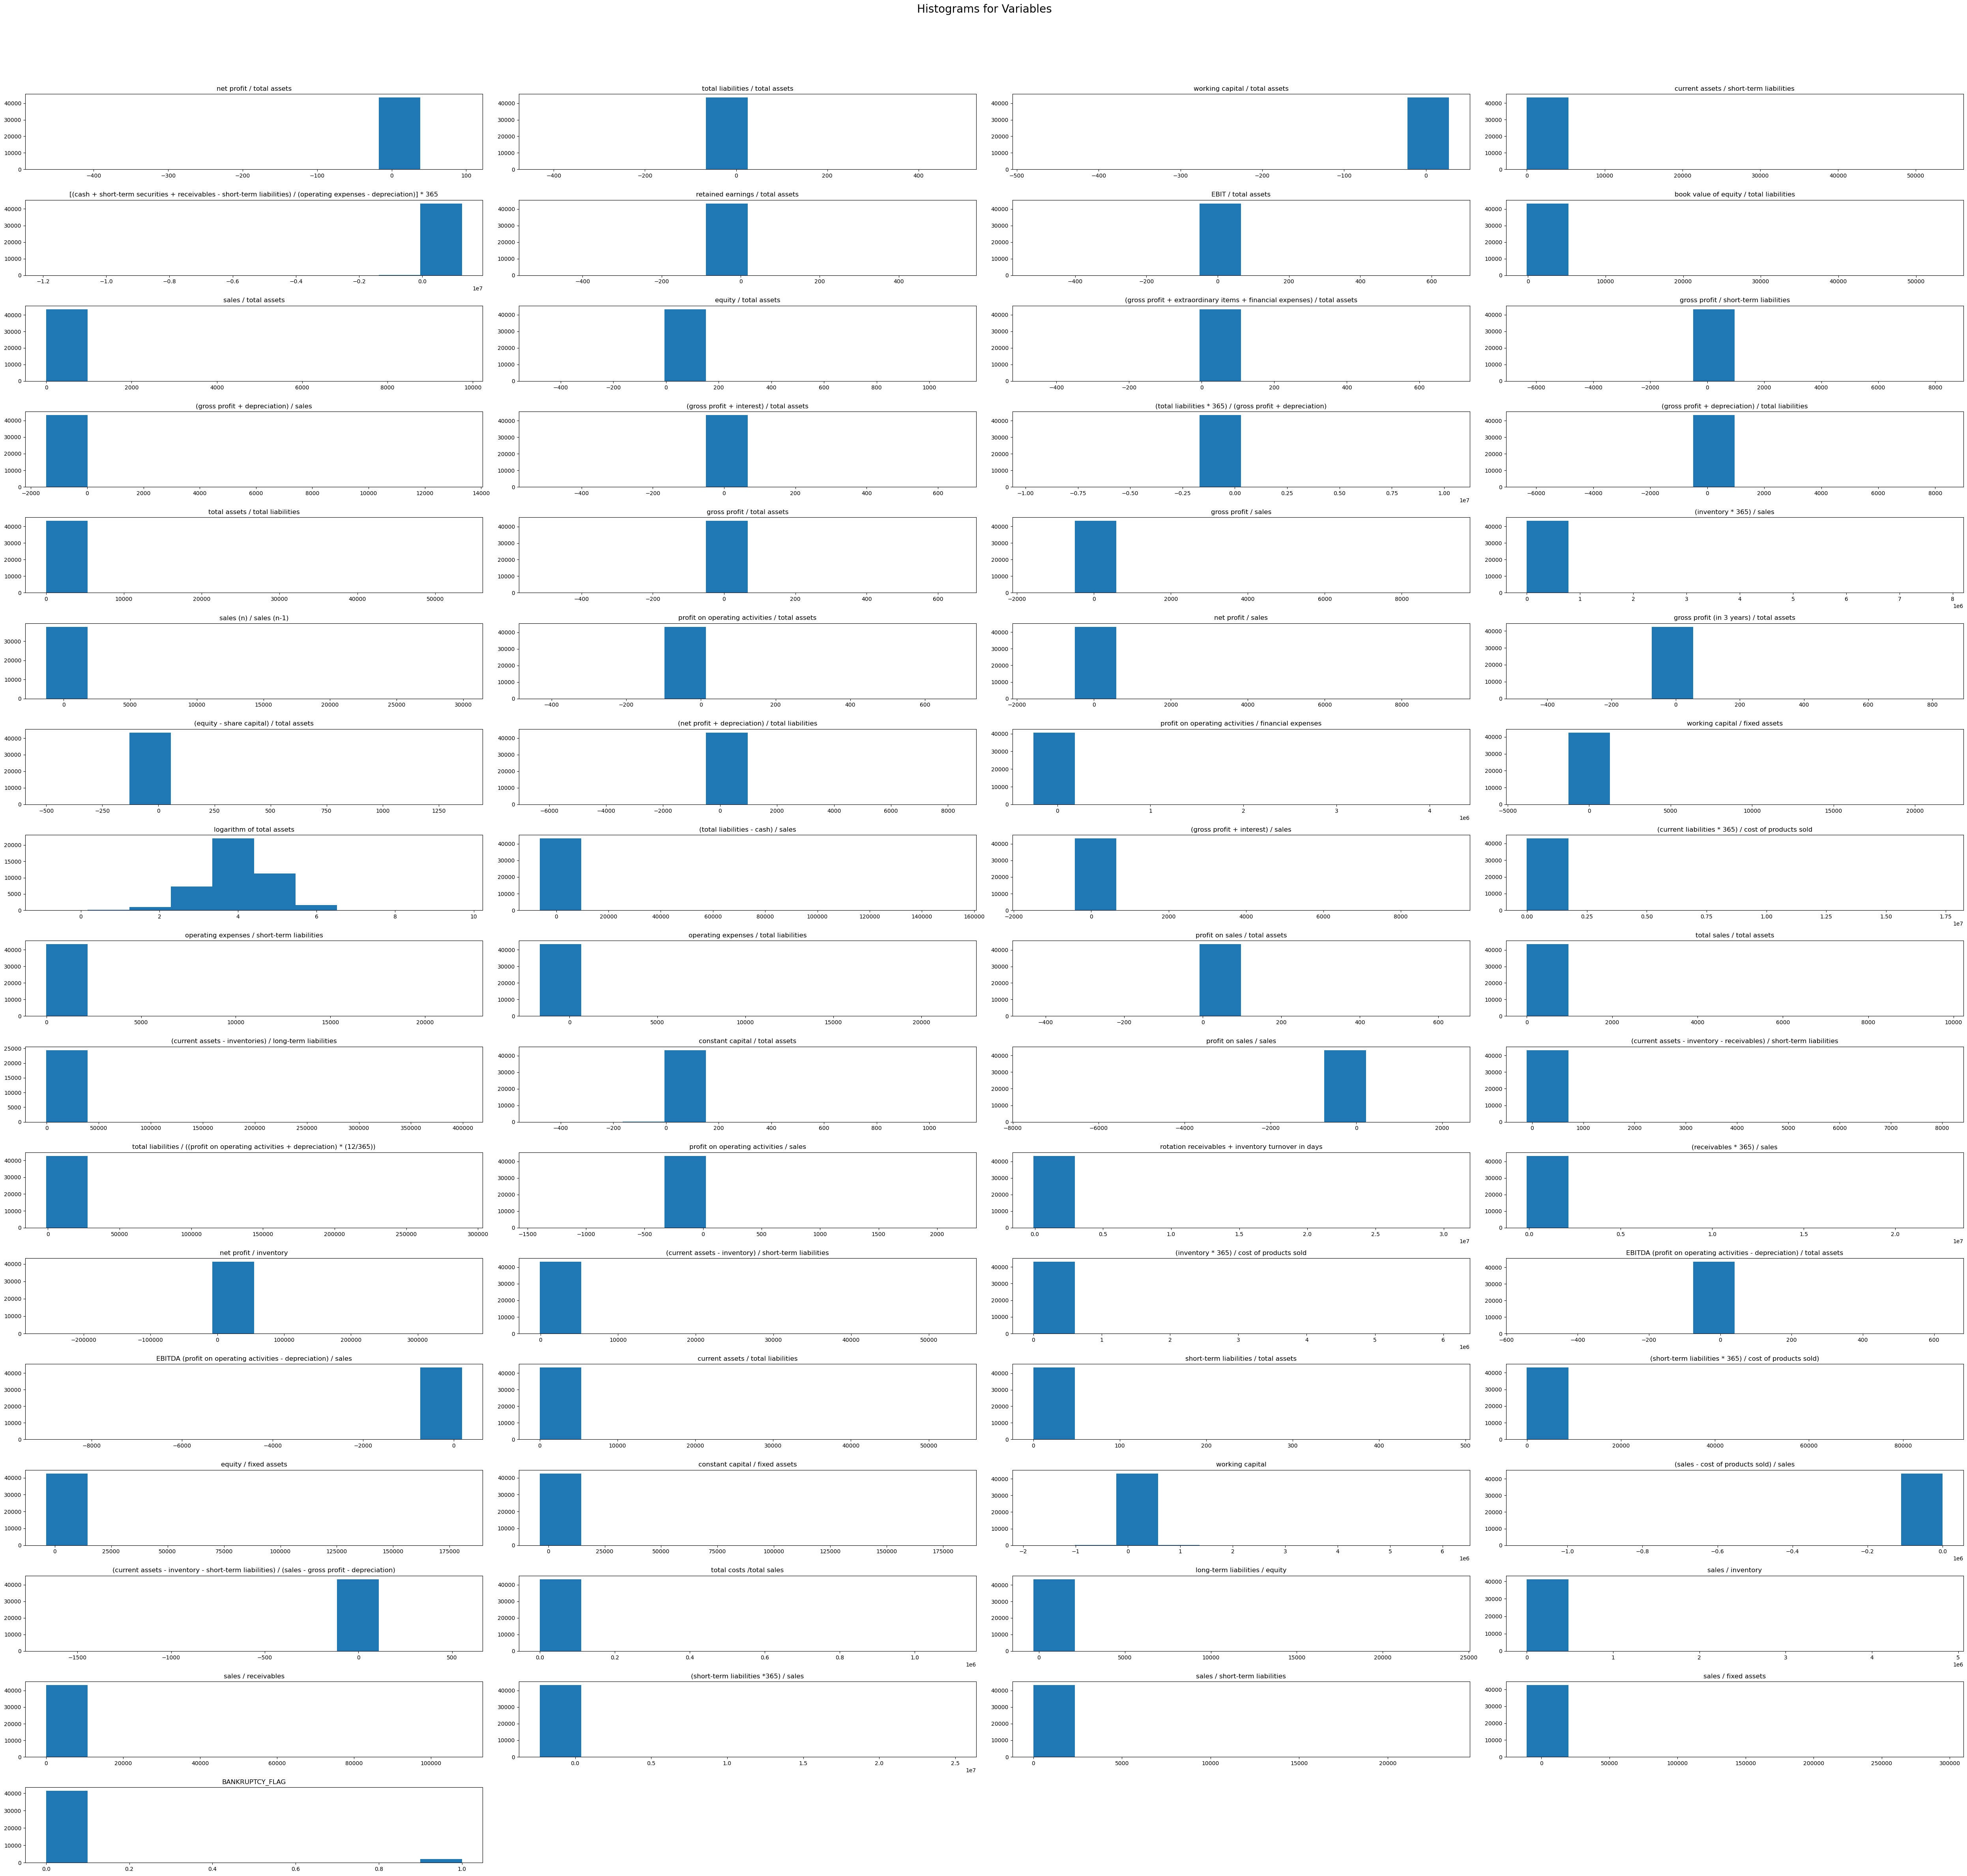

In [8]:
# Review Histograms of all columns (remove unwanted data which has been added and not relevant to visual review)
df1 = df.drop('dataset',axis=1)

# Histogram View

fig = plt.figure(figsize=(50,50))

plt.suptitle('Histograms for Variables',fontsize='20')

l = math.ceil(len(df1.columns)/4)

for i in range(len(df1.columns)):
    plt.subplot(l,4,i+1)
    f = plt.gca()
    f.set_title(df1.columns[i])
    
    plt.hist(df1.iloc[:,i])
    
plt.tight_layout(rect=[0,0.03,1,.95])

#plt.savefig("eda.pdf")

## Review Deciles of Data.

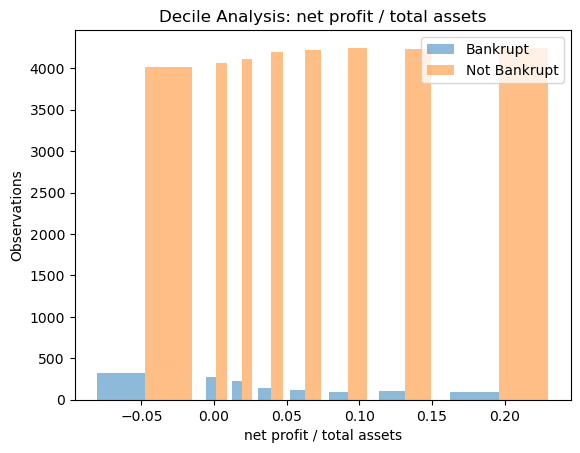

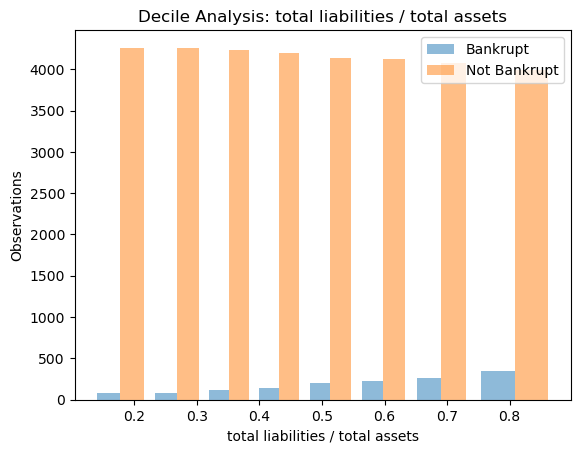

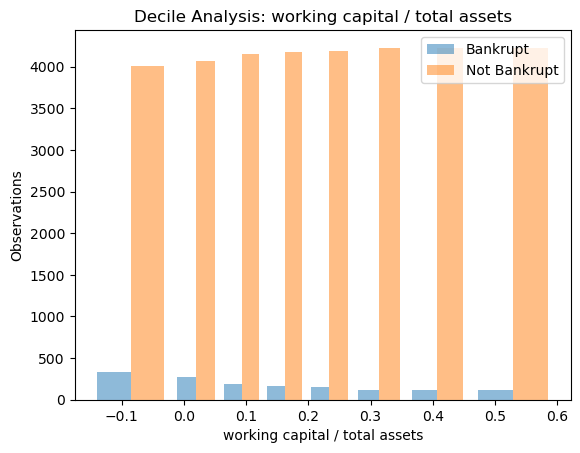

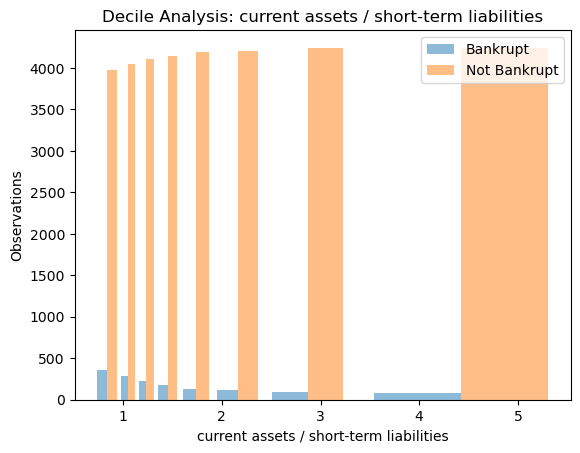

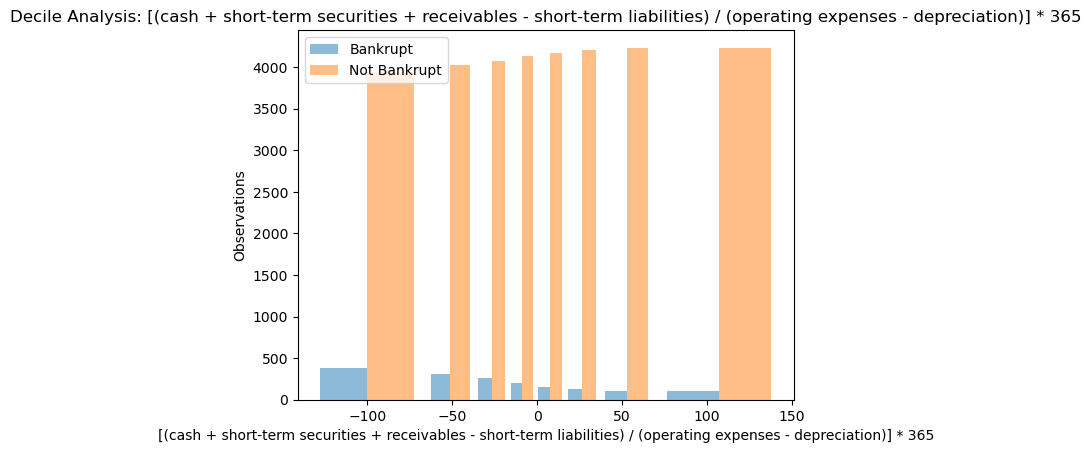

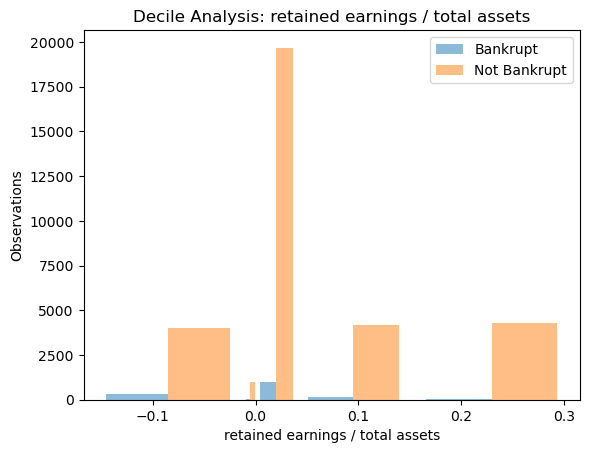

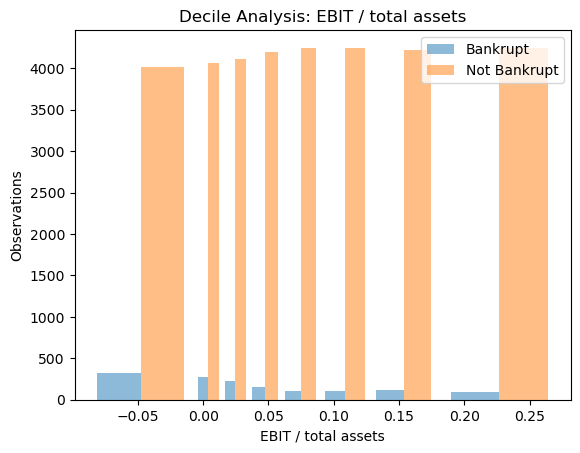

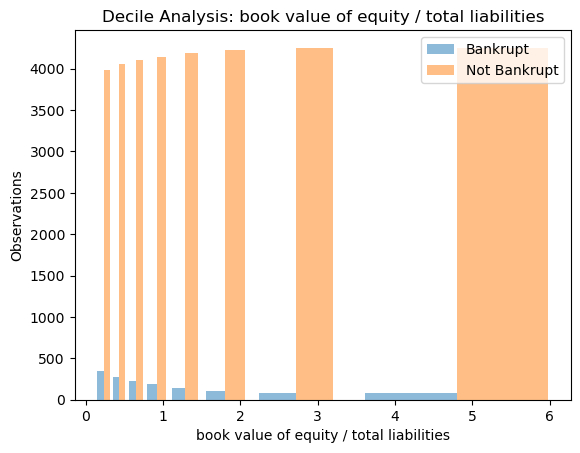

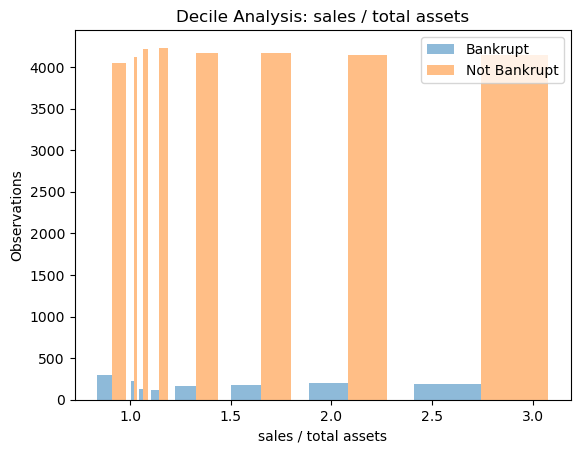

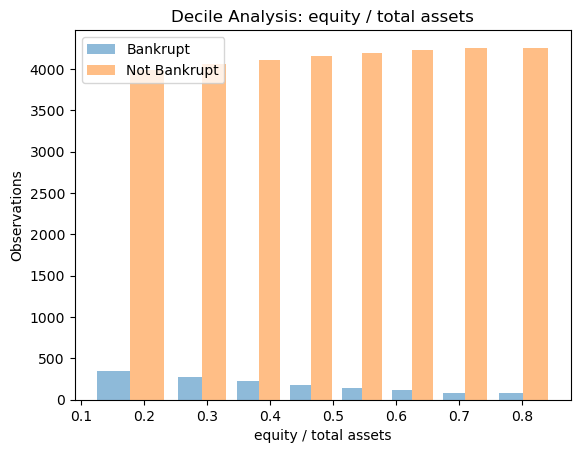

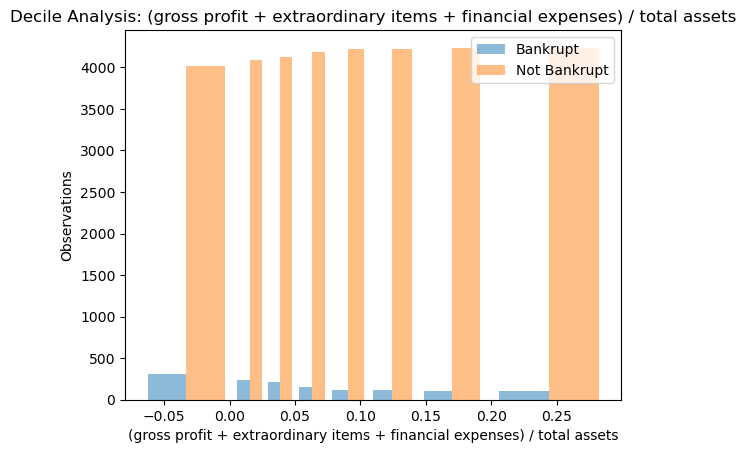

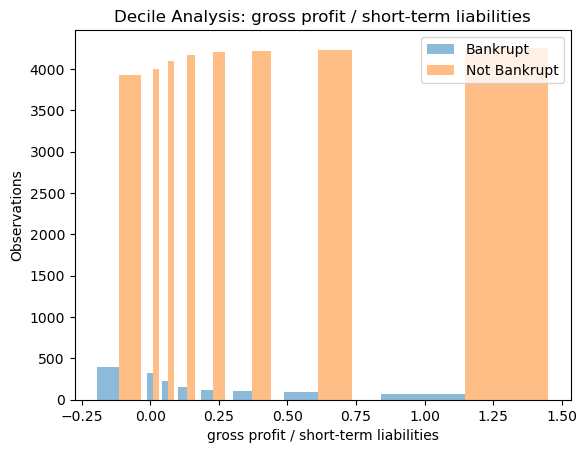

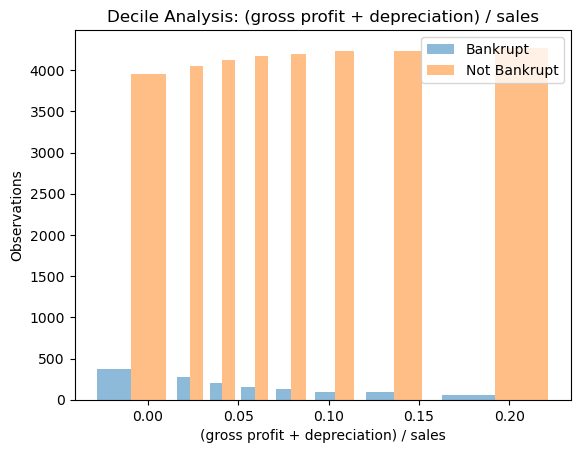

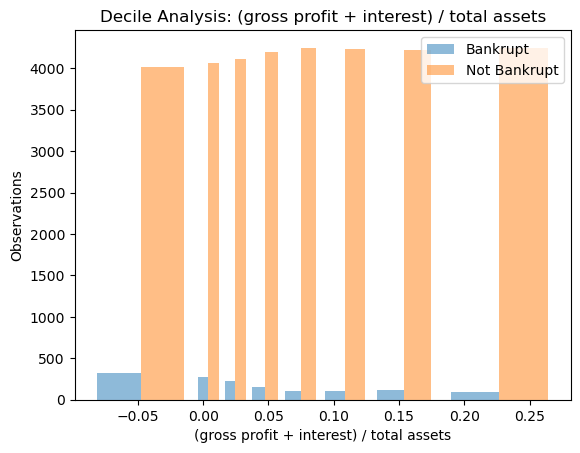

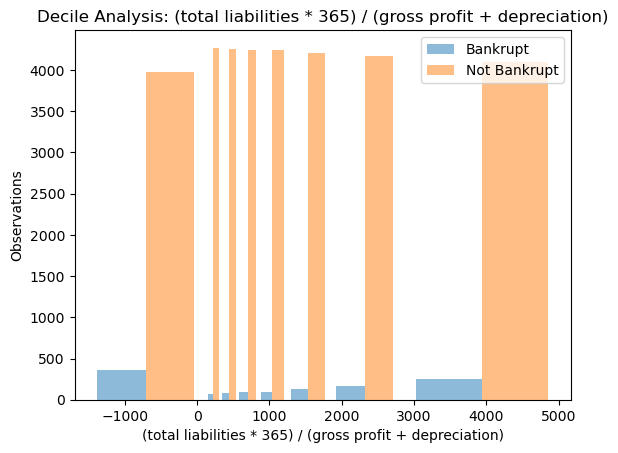

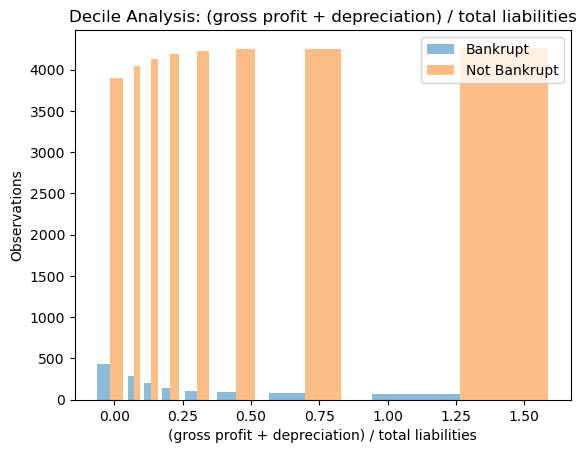

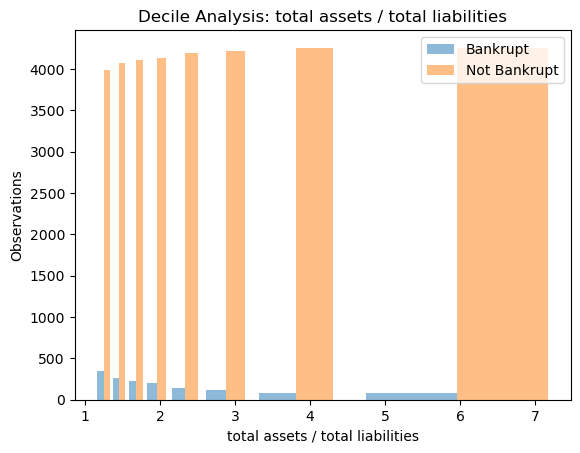

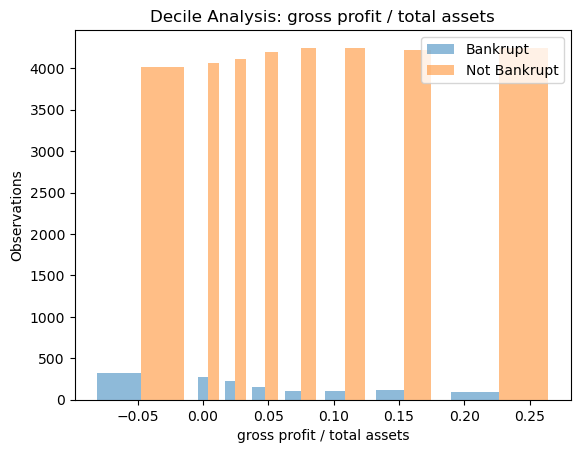

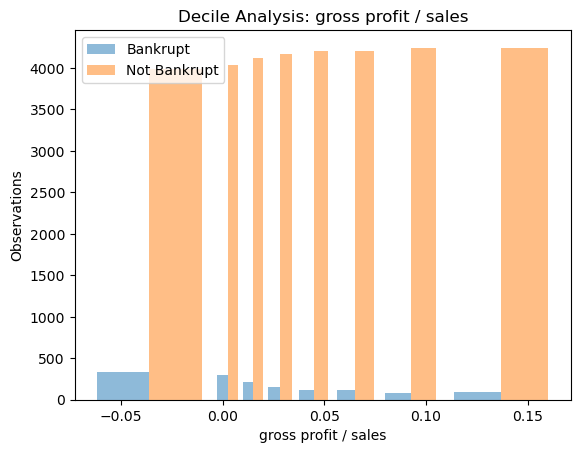

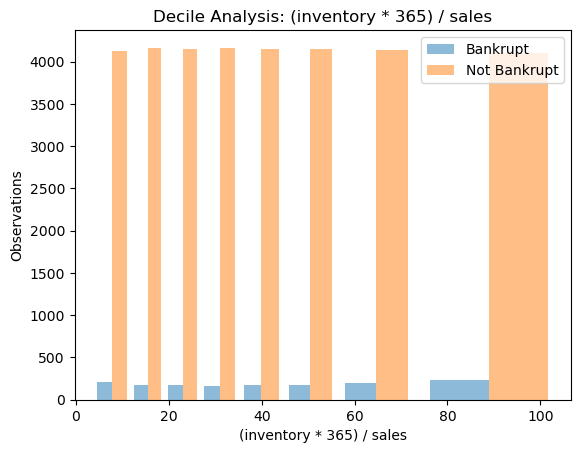

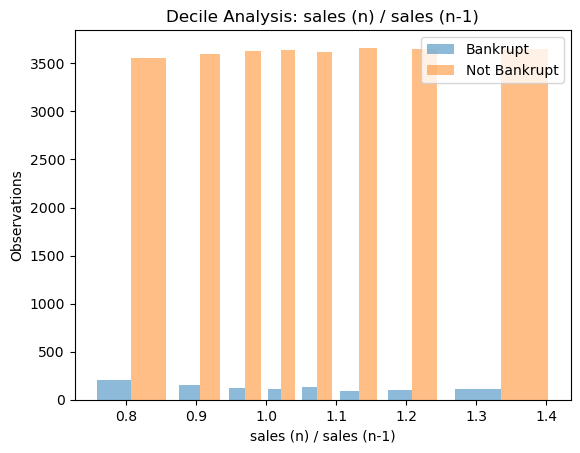

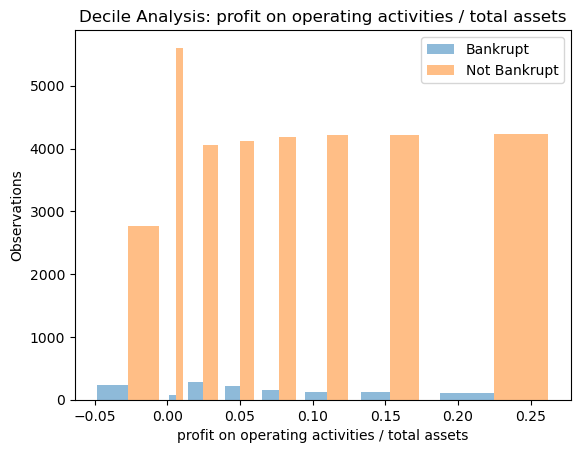

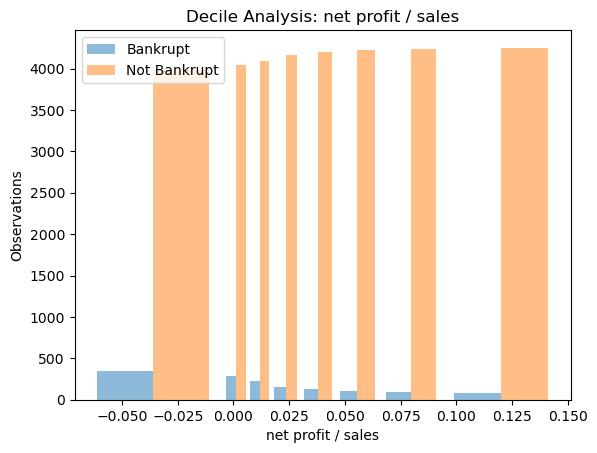

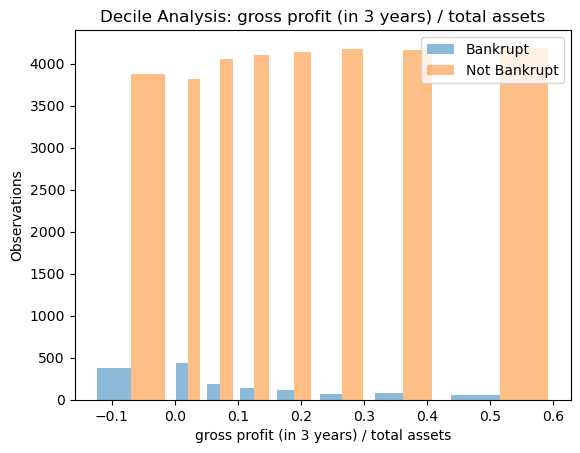

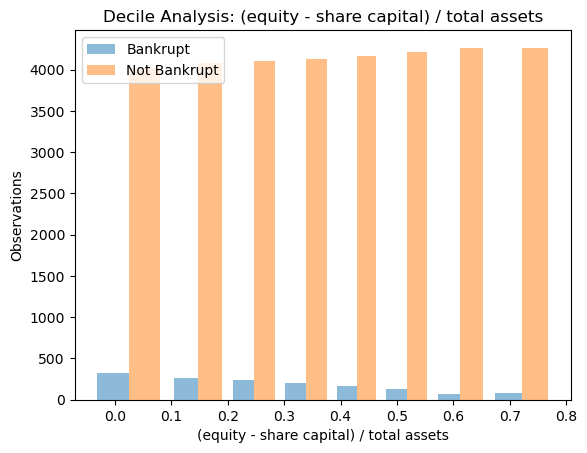

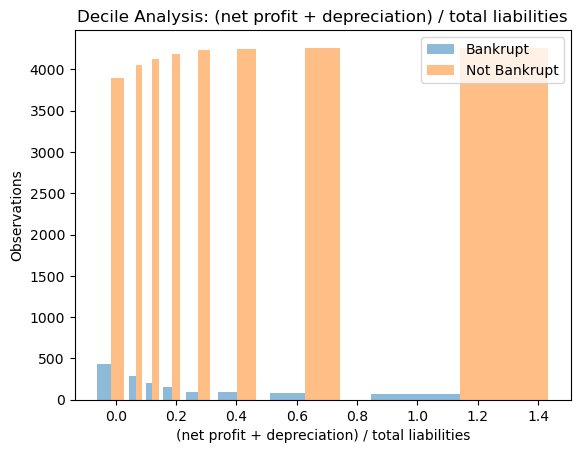

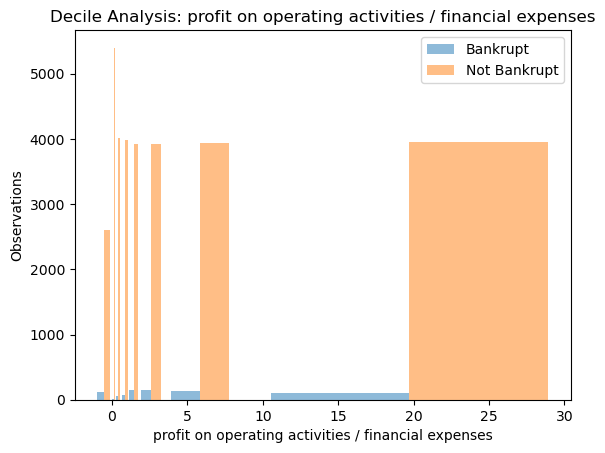

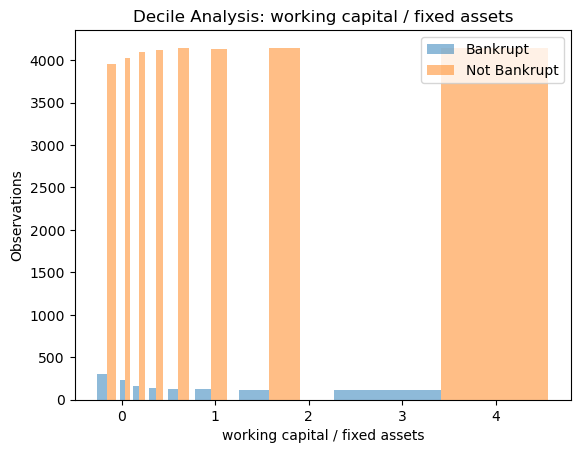

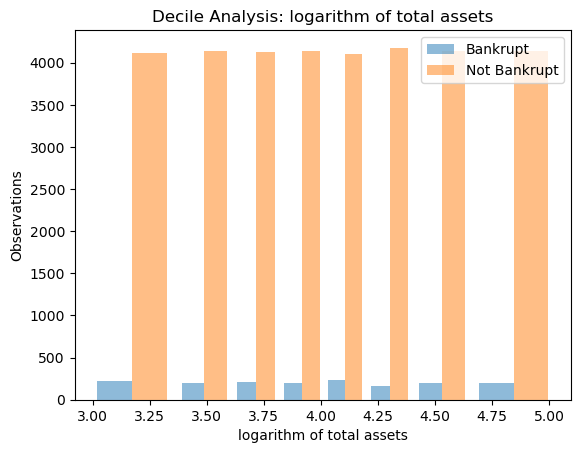

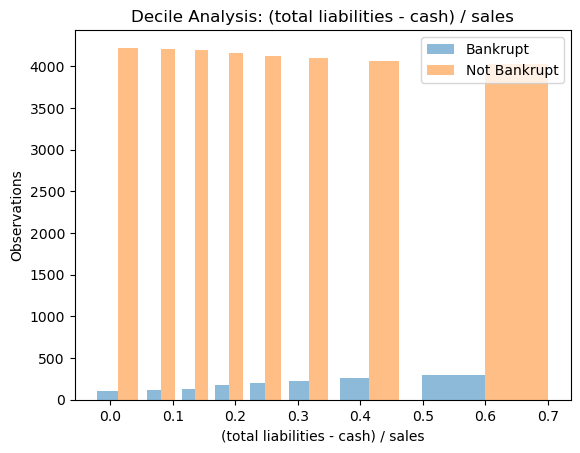

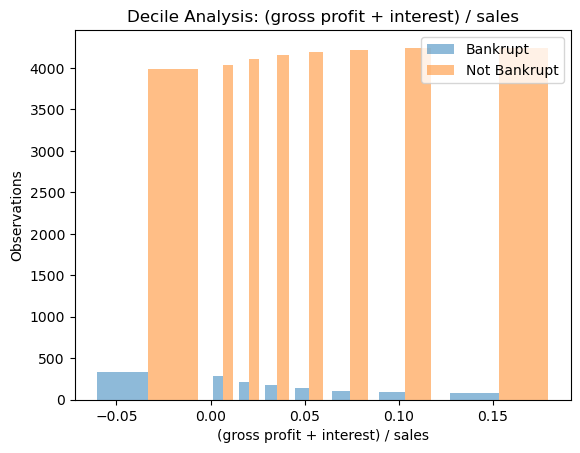

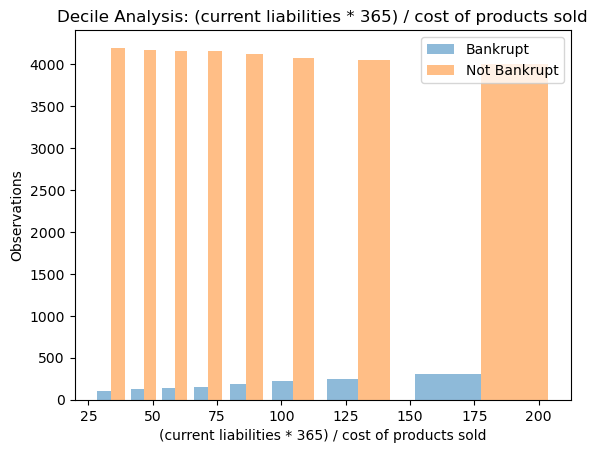

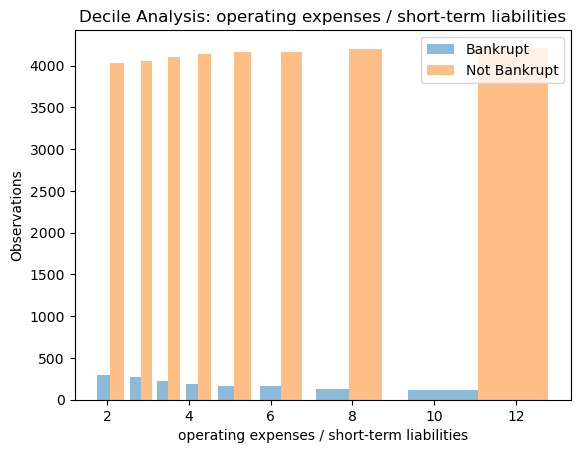

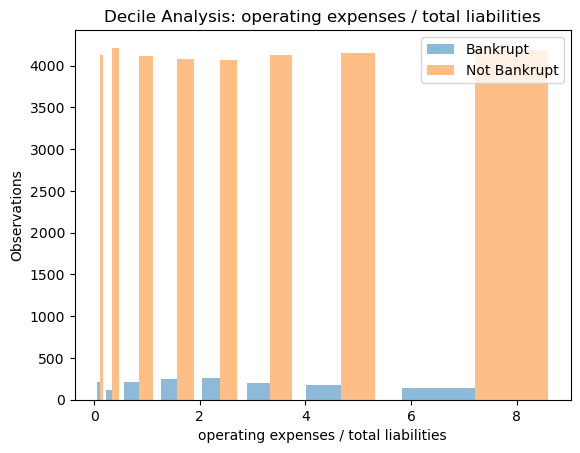

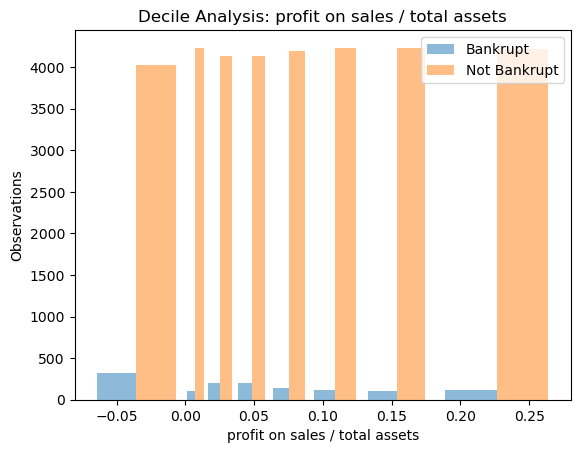

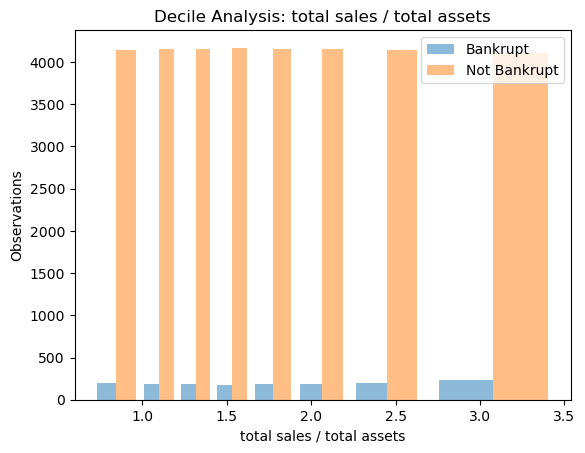

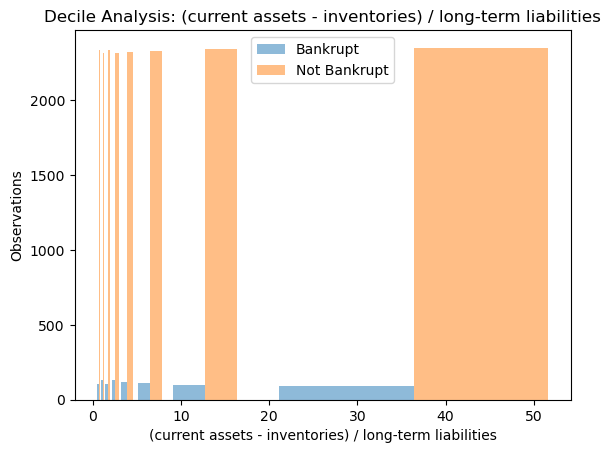

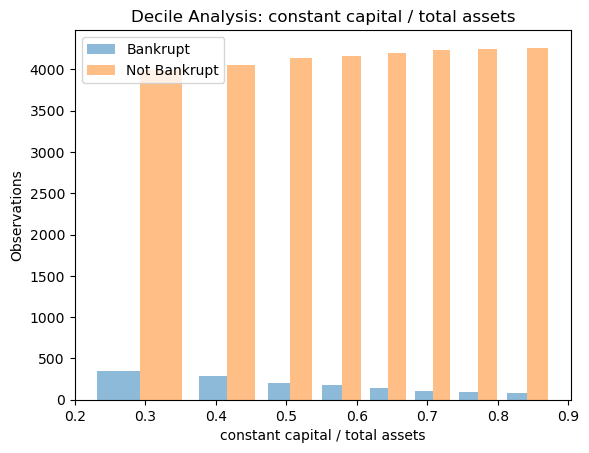

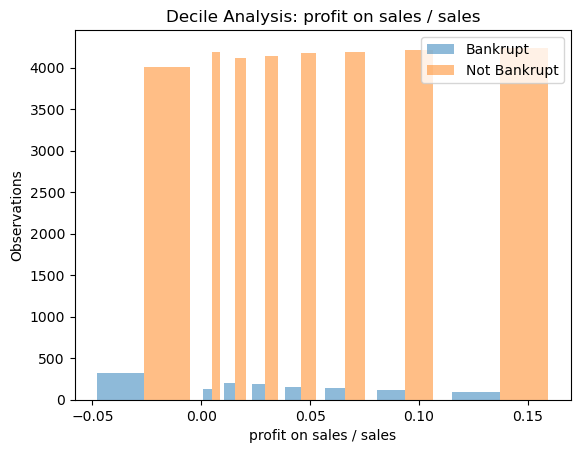

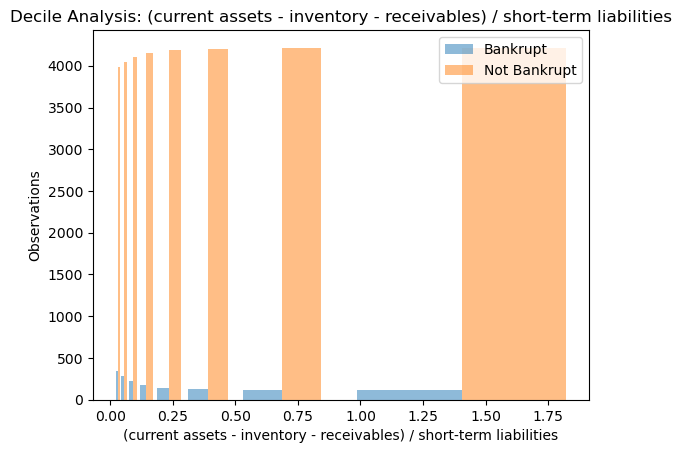

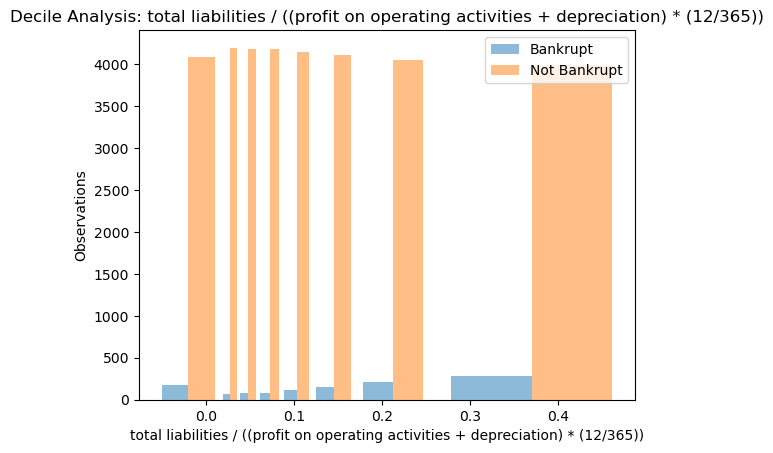

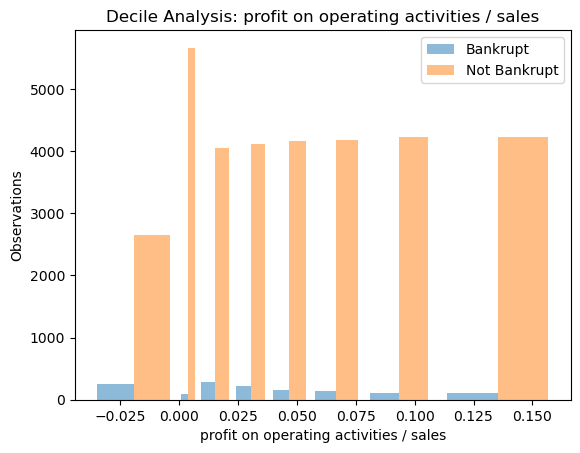

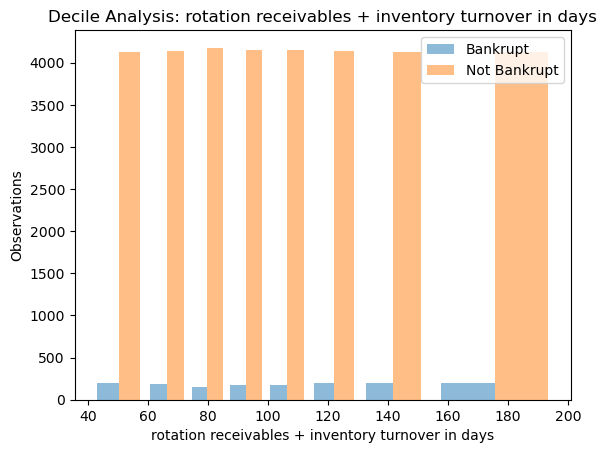

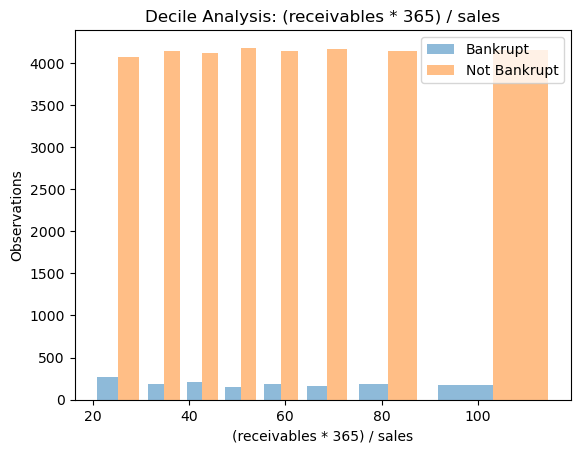

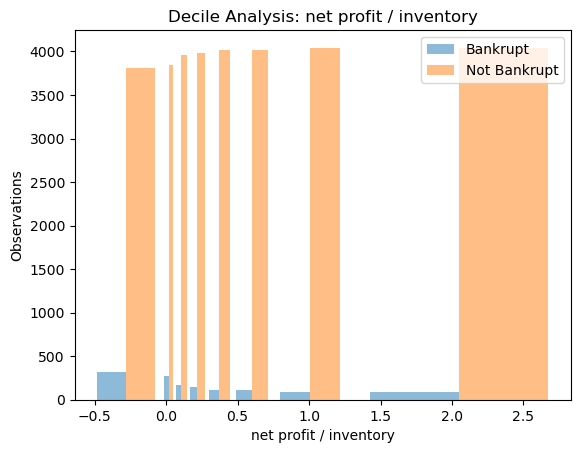

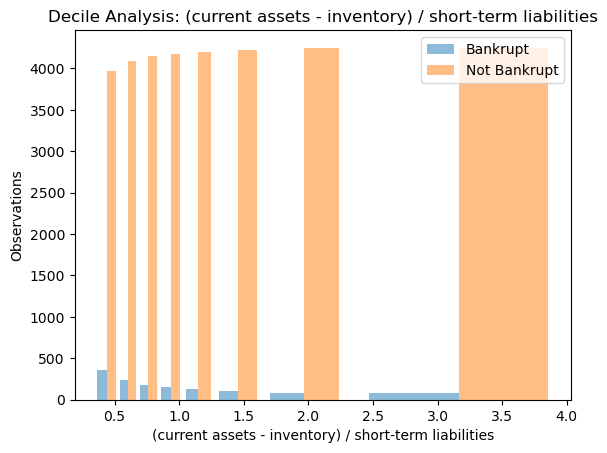

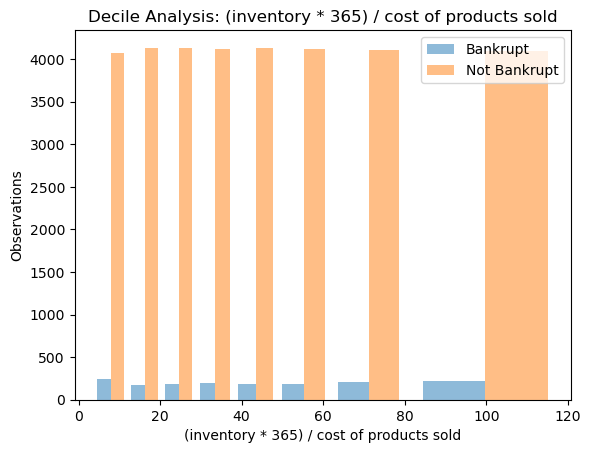

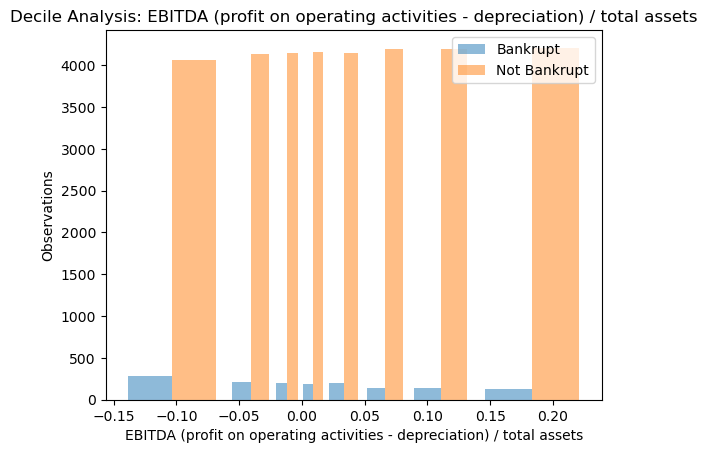

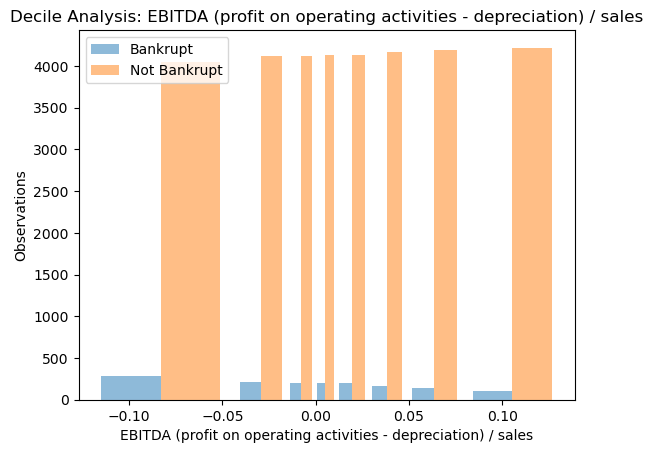

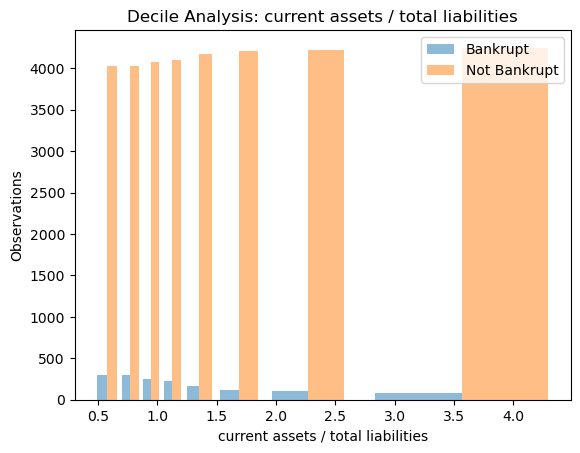

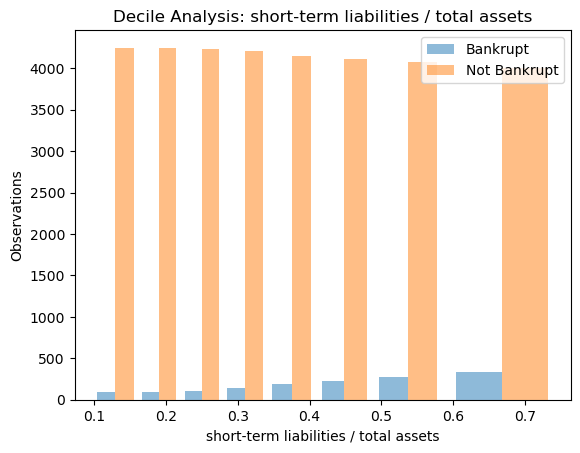

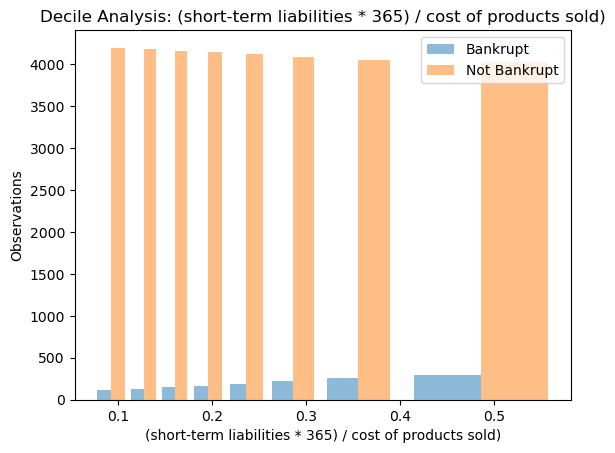

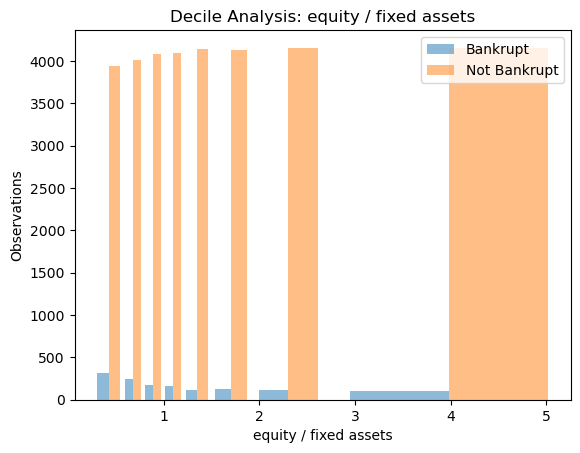

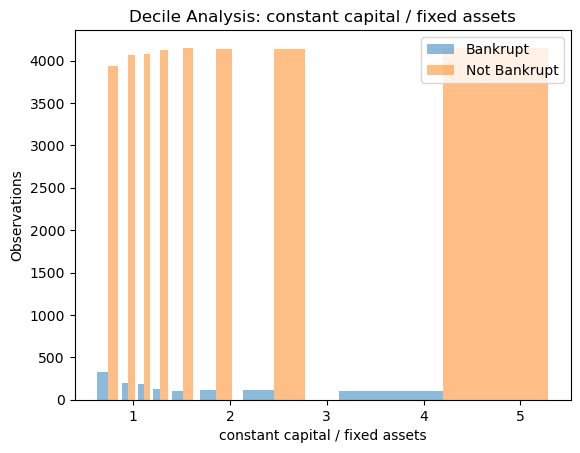

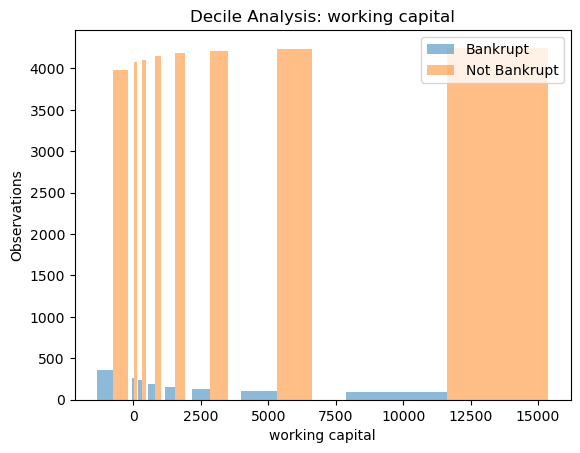

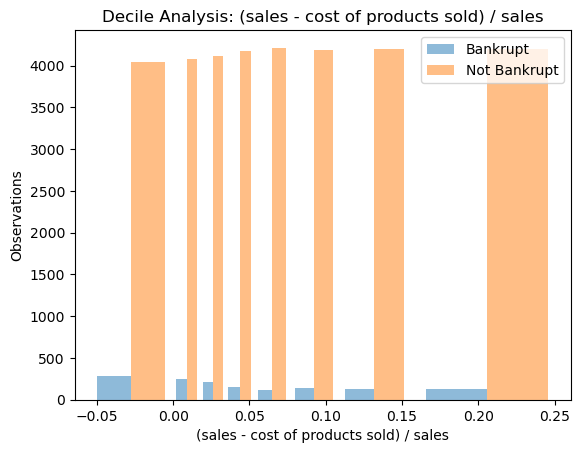

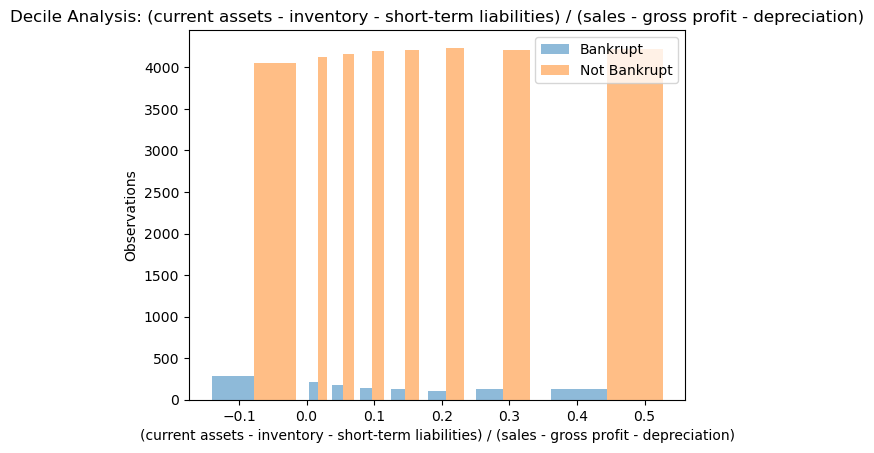

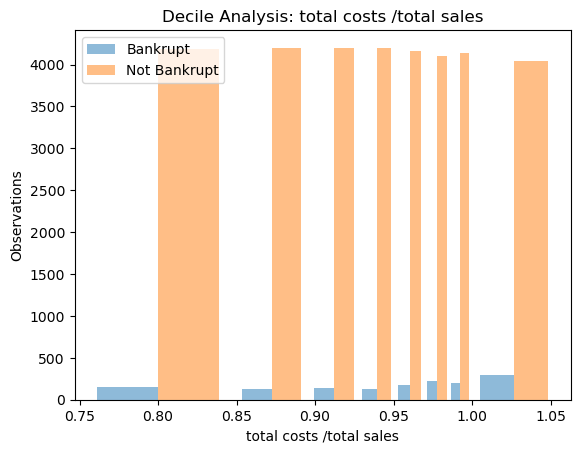

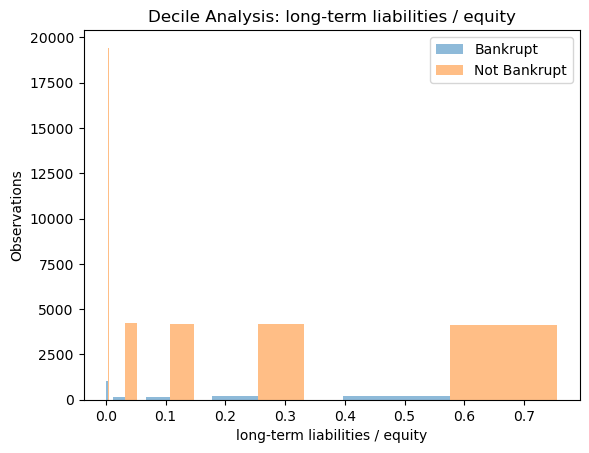

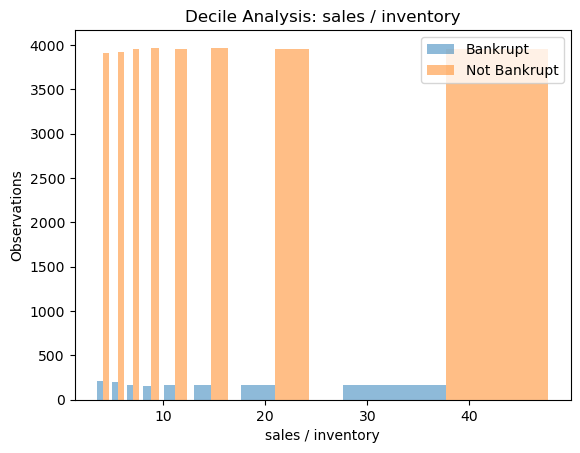

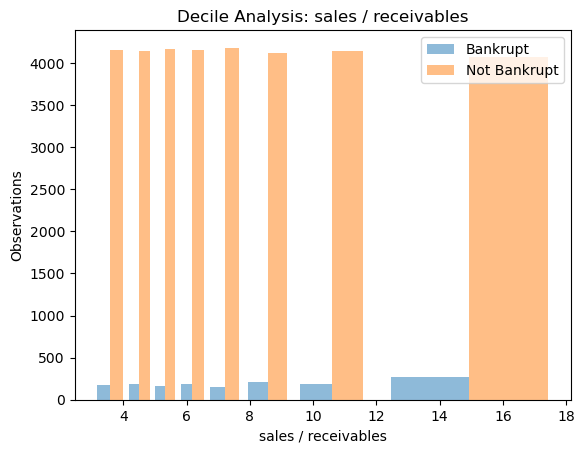

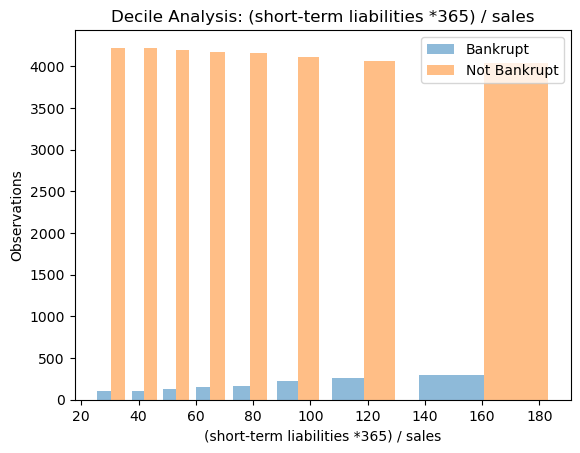

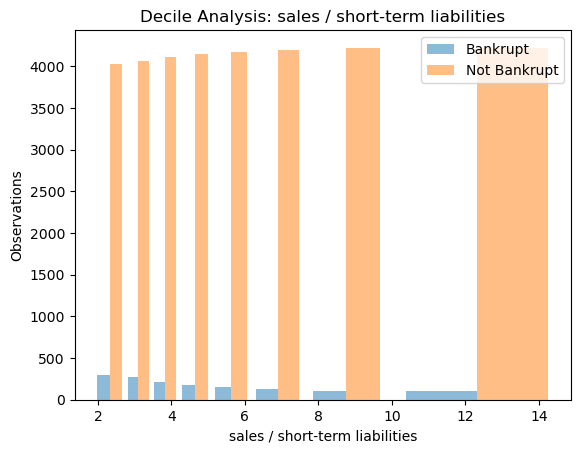

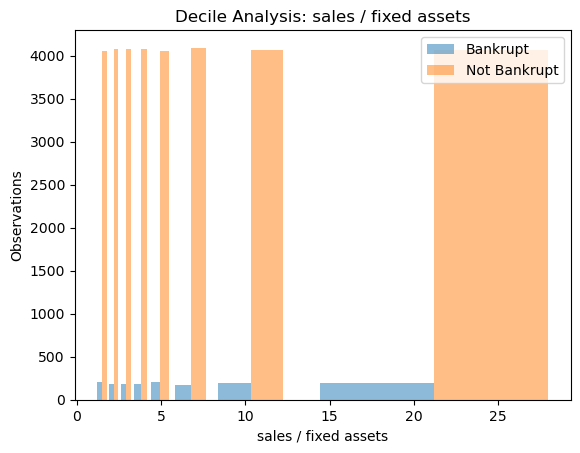

In [9]:
#### Due to variance of data, initial review of histograms difficult to understand exactly which variables are of importance and impact of outlining values, given relatively small occurances of many

decile_value_df = pd.DataFrame()

for i in df1.columns:
    if i == "BANKRUPTCY_FLAG":
        pass
    else:    
        decile_value_df = pd.concat([decile_value_df,create_decile(df1,i)])

In [10]:
# Add to previously created column_inclusion Review dataset the Decile Analysis for complete insight and 
# Understanding

column_inclusion_review_df = create_column_inclusion_review(df,
                                                            og_columns,
                                                            column_type_df,
                                                            decile_value_df)
column_inclusion_review_df.to_excel('column_inclusion_review_df.xlsx',index=False)
column_inclusion_review_df

Financial Ratio  null_records  \
0                           net profit / total assets             8   
1                    total liabilities / total assets             8   
2                      working capital / total assets             8   
3             current assets / short-term liabilities           134   
4   [(cash + short-term securities + receivables -...            89   
..                                                ...           ...   
60                                sales / receivables           102   
61              (short-term liabilities *365) / sales           127   
62                     sales / short-term liabilities           134   
63                               sales / fixed assets           812   
64                                    BANKRUPTCY_FLAG             0   

    zero_records   max_value    min_value  mean_value   std_dev  \
0            240       94.28      -463.89        0.04      2.99   
1             89      480.96      -430.87        0.59      5.84   
2             24       28.34      -479.96        0.11      5.44   
3              2    53433.00        -0.40        6.31    295.43   
4             43  1250100.00 -11903000.00     -385.35  61243.03   
..           ...         ...          ...         ...       ...   
60           122   108000.00       -12.66       17.03    553.05   
61           121 25016000.00  -2336500.00     1502.33 139266.70   
62           118    23454.00        -1.54        9.34    124.18   
63            88   294770.00    -10677.00       72.79   2369.34   
64         41314        1.00         0.00        0.05      0.21   

    positive_values  negative_values  Value Between 0 to 1  ...  \
0             33865             9292                 33999  ...   
1             43305                3                 41116  ...   
2             33804             9569                 33797  ...   
3             43267                2                  9569  ...   
4             21356            21917                   319  ...   
..              ...              ...                   ...  ...   
60            43175                6                   670  ...   
61            43153                4                   157  ...   
62            43149                4                  1539  ...   
63            42500                5                  3437  ...   
64             2091                0                 41314  ...   

    Ratio Classification     0.1    0.2    0.3    0.4   0.5   0.6    0.7  \
0    Profitability Ratio   -0.09  -0.01   0.01   0.03  0.05  0.08   0.11   
1   Capitalization Ratio    0.13   0.22   0.31   0.39  0.47  0.55   0.64   
2         Liqudity Ratio   -0.15  -0.02   0.06   0.13  0.20  0.27   0.36   
3   Capitalization Ratio    0.71   0.96   1.14   1.33  1.57  1.90   2.42   
4    Profitability Ratio -134.63 -65.60 -36.54 -16.94 -1.03 16.05  37.02   
..                   ...     ...    ...    ...    ...   ...   ...    ...   
60        Turnover Ratio    3.08   4.08   4.92   5.72  6.64  7.77   9.34   
61        Turnover Ratio   24.40  36.56  47.50  58.83 71.33 86.46 104.77   
62        Turnover Ratio    1.90   2.73   3.46   4.20  5.09  6.16   7.63   
63  Capitalization Ratio    1.15   1.84   2.53   3.30  4.28  5.63   7.89   
64       Target Variable     NaN    NaN    NaN    NaN   NaN   NaN    NaN   

      0.8    0.9  
0    0.15   0.24  
1    0.74   0.88  
2    0.46   0.60  
3    3.32   5.53  
4   68.51 145.61  
..    ...    ...  
60  11.83  18.06  
61 132.46 188.74  
62   9.89  14.74  
63  12.73  29.65  
64    NaN    NaN  

[65 rows x 23 columns]

## Review Correlations with Data.

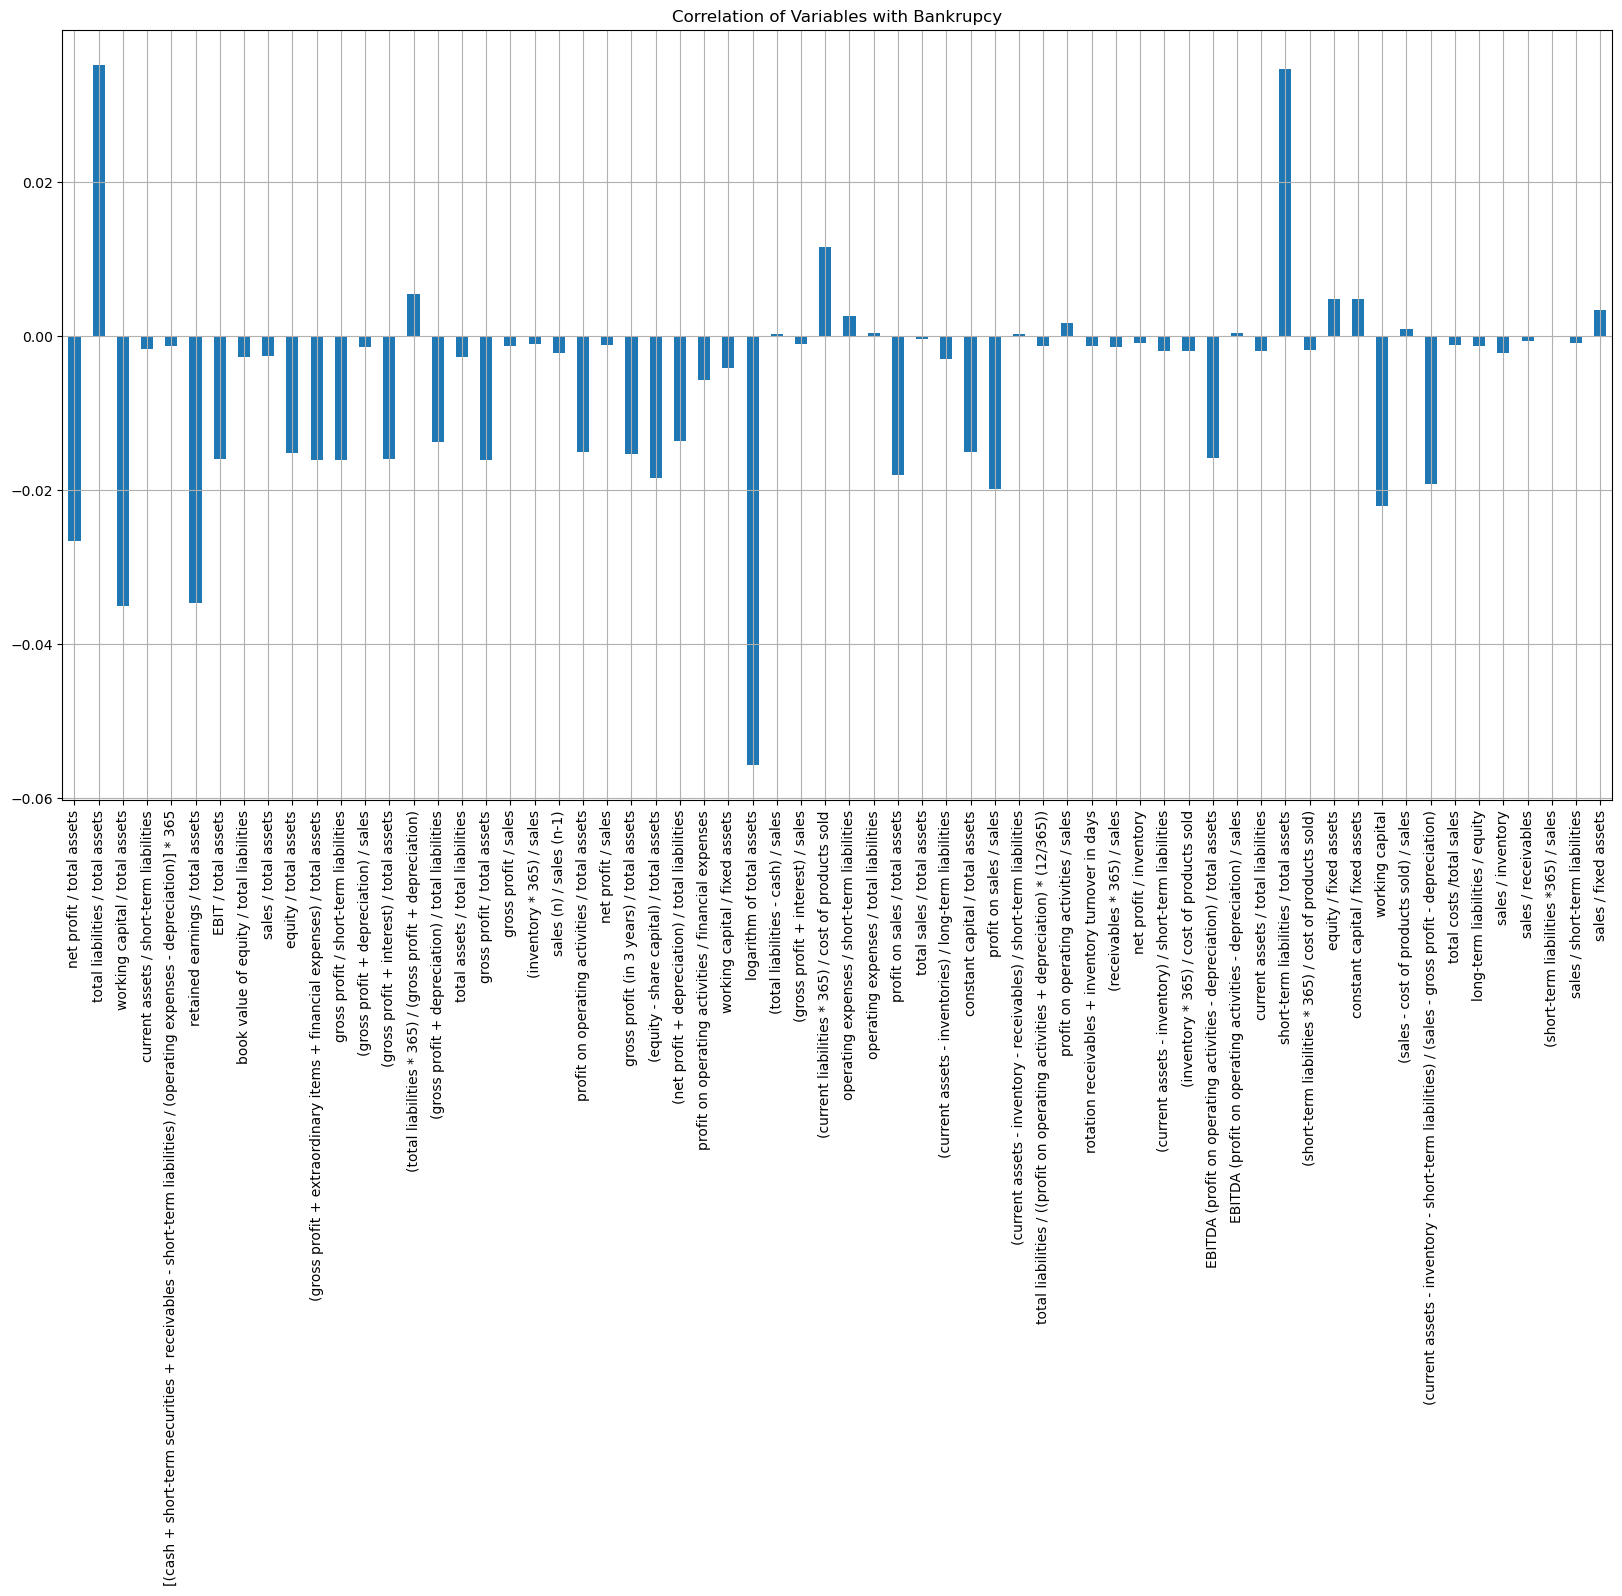

In [11]:
# Review Correlation of Variables with Target

df1.drop(['BANKRUPTCY_FLAG'],axis=1).corrwith(df1.BANKRUPTCY_FLAG).plot.bar(figsize=(20,10),title='Correlation of Variables with Bankrupcy',rot=90,grid=True)
plt.show()

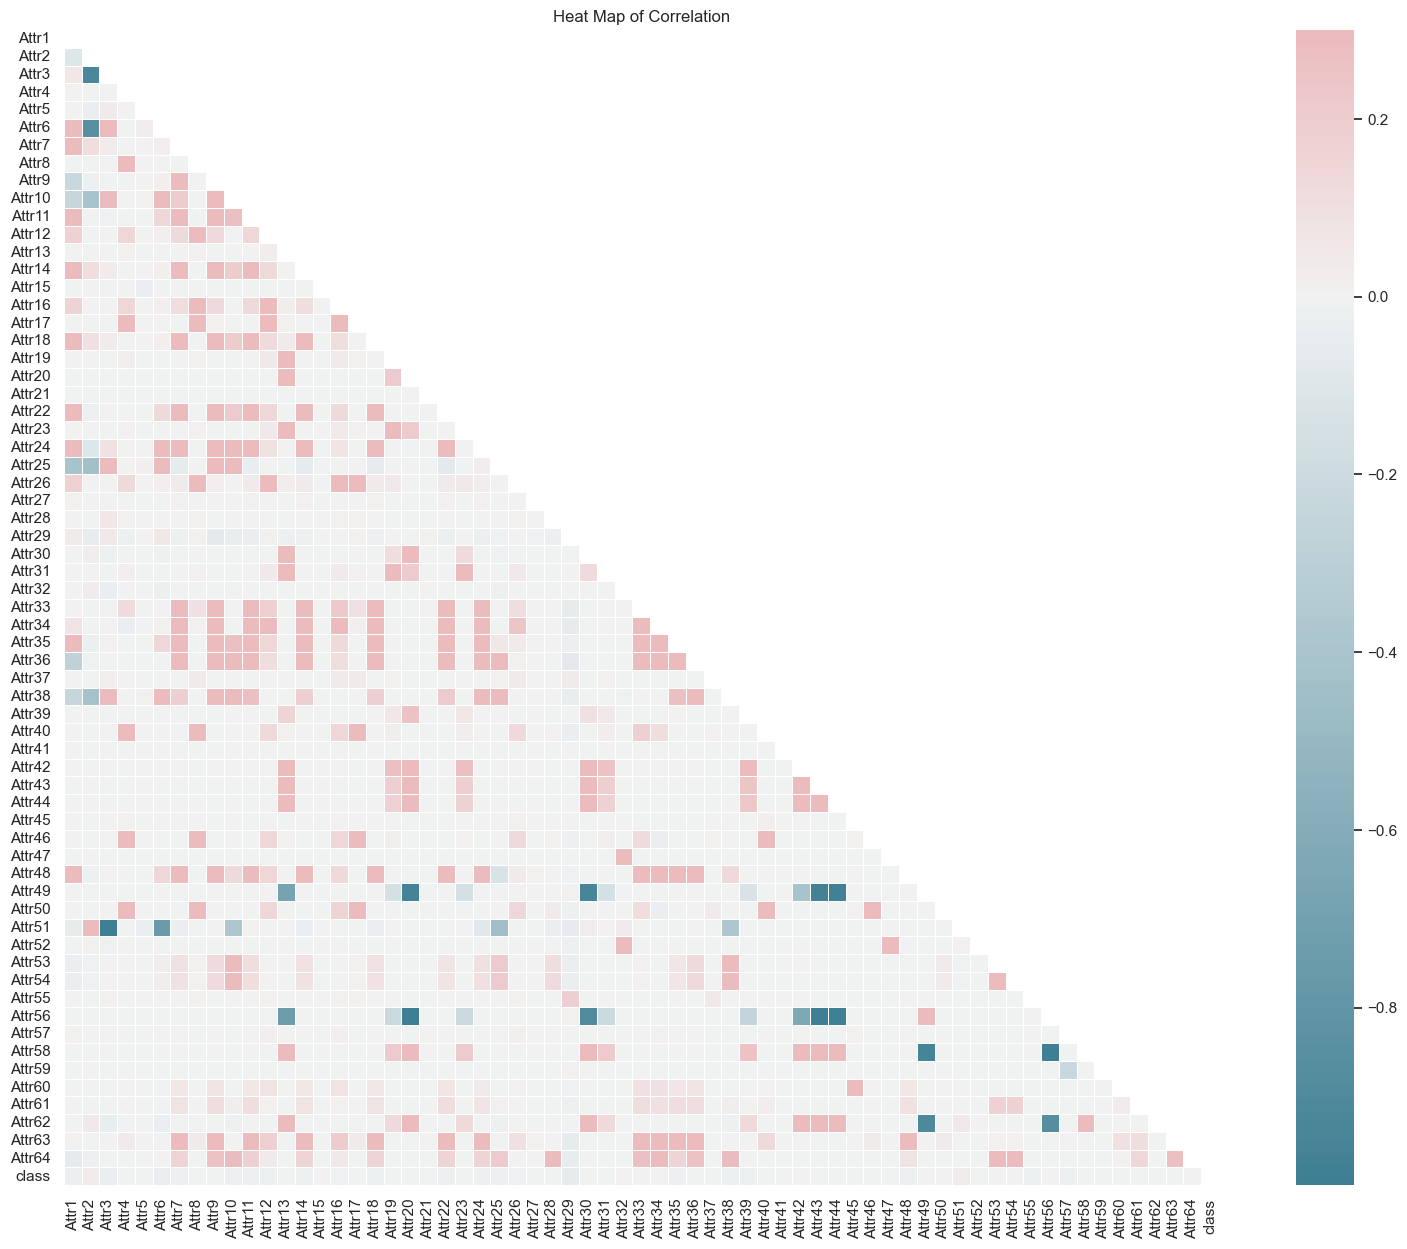

In [12]:
# Review Correlation of Data with Other Variables

create_heatmap(df1.rename(columns={column_data.iloc[x]['FINANCIAL_RATIO']:column_data.iloc[x]['COLUMN_NAME'] for x in range(0,len(column_data))})) 

### After reviewing the initial EDA Histogram, Decile Analysis, Column Names and Correlations what do we know.


1. Considerable blanks on certain variables.
2. Correlation amongst variables appears to be a concern, could be a problem. Specifically, multicolinearity.
3. Outliers are skewing meaningful interpretation of Histogram. Utilized Decile to partially overcome, how do these impact model?

In [13]:
project_reference_dictionary['Warnings'] = ['Blank Values in Dataset',
                                            'Correlation Amongst Variables, Multicolinearity?',
                                            'Outliers and distribution']
project_reference_dictionary['Step 2. Review Data'] = 'Completed'

## Data Clean Up.


The approach to be taken for data cleaning is as follows:
1. Review data at the Attribute Level and apply cleaning as approrpriate ( focusing on cleaning data we believe it relevant, and necessary)
2. Review data at the individual record level (after attribute has been cleaned, and perhaps resolved) and impute, delete, etc as appropriate 

## Tier 1 Variables

In [14]:
# Based on Correlation with Bankrupcy we have identified 7 Variables, which we will prioritize as Tier1. 
# These variables meet both a intutive reference with what is believed a pragmatic model and appears to mathematically be relevant.

tier1 = ['net profit / total assets',
         'total liabilities / total assets',
         'working capital / total assets',
         'retained earnings / total assets',
         'logarithm of total assets',
         'working capital',
         'short-term liabilities / total assets']

column_inclusion_review_df[column_inclusion_review_df['Financial Ratio'].isin(tier1)][['Financial Ratio','Ratio Classification']]

# Review Each of these through process: 
# 1. How to treat NA
# 2. How to Outliers
# 3. How to treat Similiar Variables
# 

Financial Ratio  Ratio Classification
0               net profit / total assets   Profitability Ratio
1        total liabilities / total assets  Capitalization Ratio
2          working capital / total assets        Liqudity Ratio
5        retained earnings / total assets  Capitalization Ratio
28              logarithm of total assets  Capitalization Ratio
50  short-term liabilities / total assets  Capitalization Ratio
54                        working capital        Liqudity Ratio

## Data Review and Cleaning Process

remove_reason
                                    43396
Net Profit/ Total Assets is Null        8
Working capital is Null                 1
Name: count, dtype: int64
                                                      1
Financial Ratio        total liabilities / total assets
null_records                                          0
zero_records                                         91
max_value                                        480.96
min_value                                          0.00
mean_value                                         0.60
std_dev                                            5.45
positive_values                                   43305
negative_values                                       0
Value Between 0 to 1                              41118
Value Greater than 1                               2278
Value Less than -1%                                   0
Value between -1 to 0                                 0
Ratio Classification               Capitalization 

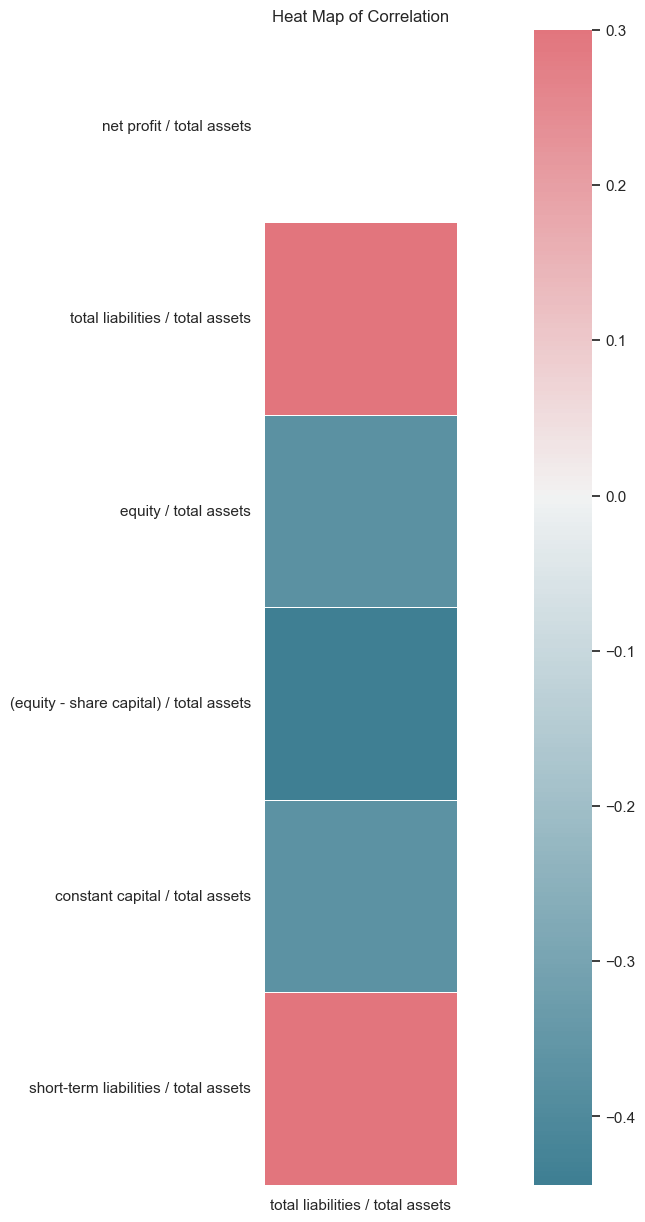

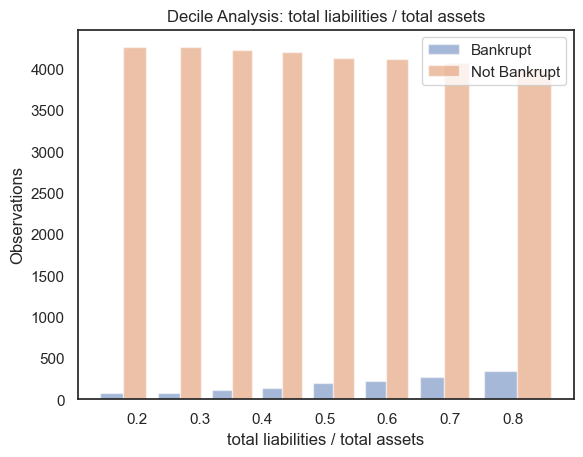

Top 20 Records
       total liabilities / total assets  BANKRUPTCY_FLAG
6800                              16.64                0
1499                              16.67                0
5001                              20.40                0
3466                              21.26                0
1497                              24.91                0
3017                              25.00                0
1392                              25.43                0
1672                              25.64                0
9587                              40.16                1
5761                              46.03                1
1456                              46.91                0
8242                              54.23                0
5613                              72.42                1
5323                             110.69                0
6921                             441.50                1
4232                             441.74                0
10321           

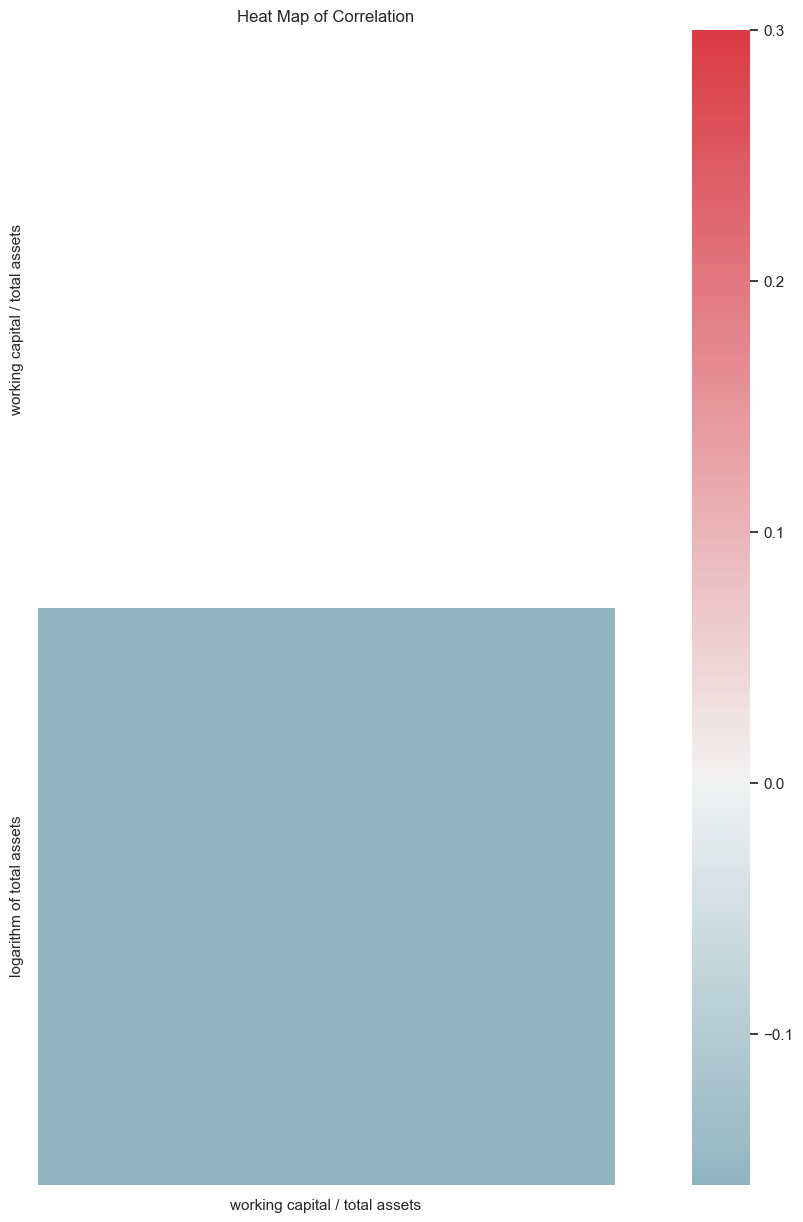

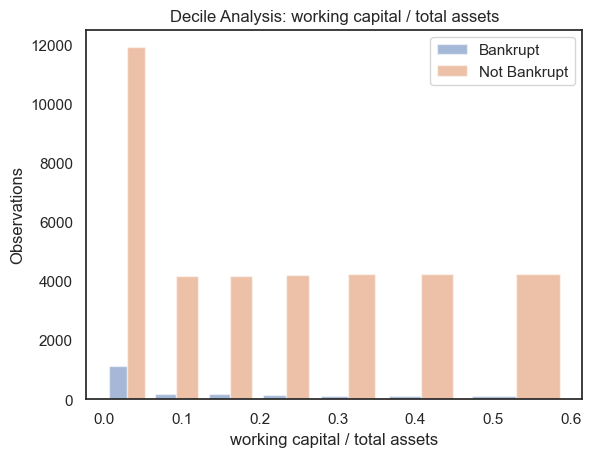

Top 20 Records
      working capital / total assets  BANKRUPTCY_FLAG
7509                            1.00                0
4200                            1.00                0
279                             1.00                0
4318                            1.00                0
7271                            1.00                0
4115                            1.00                0
6110                            1.00                0
5583                            1.00                1
2619                            1.00                0
2051                            1.00                0
6924                            1.05                0
4148                            1.39                0
3073                            4.18                0
2457                            5.50                0
2496                            9.63                0
3131                           11.93                0
1555                           17.63                0
2503         

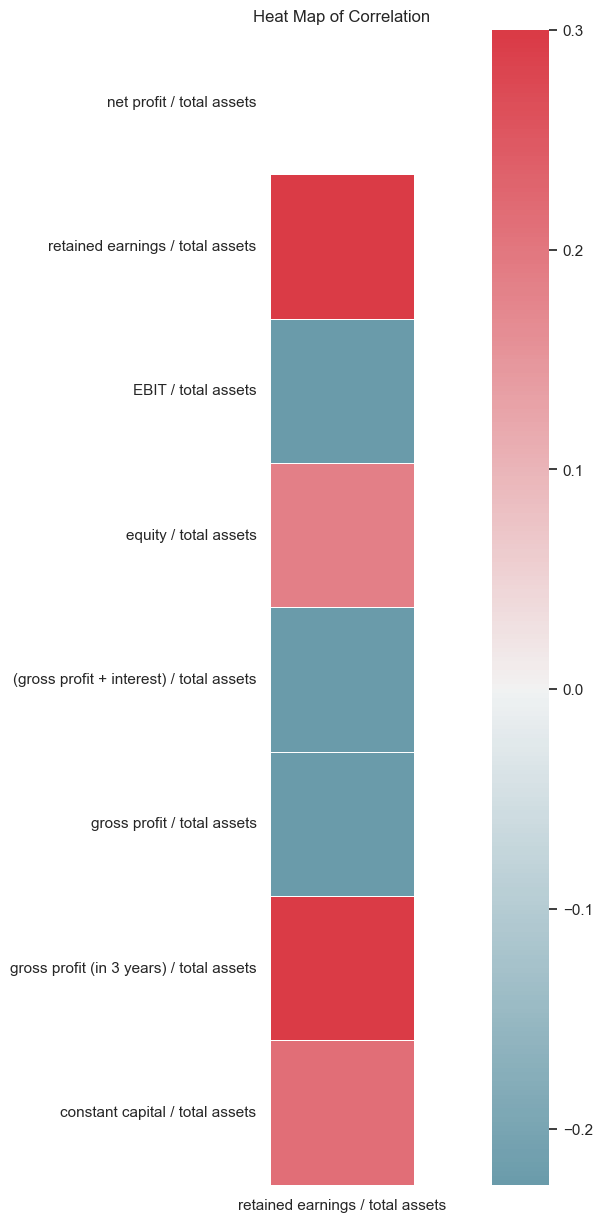

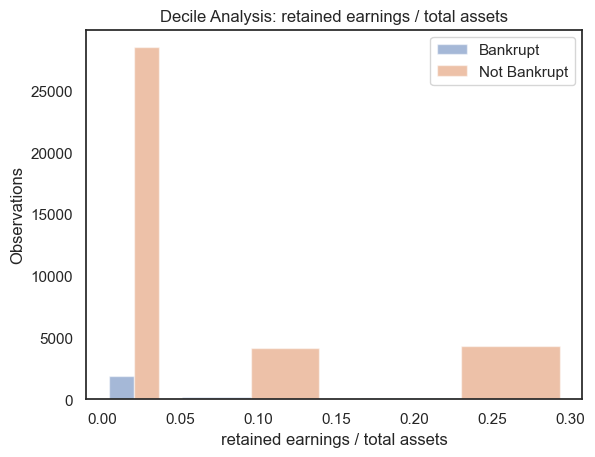

Top 20 Records
      retained earnings / total assets  BANKRUPTCY_FLAG
7932                              4.55                0
4472                              7.80                0
5087                             14.76                0
5681                             17.11                0
9741                             25.41                0
3908                             27.53                0
9827                             35.55                1
3466                             36.74                0
5291                             39.15                0
6293                             40.51                0
8042                             45.53                0
3704                             63.02                0
660                              75.26                0
3422                             77.49                0
5732                            137.05                0
1195                            203.15                0
1032                            2

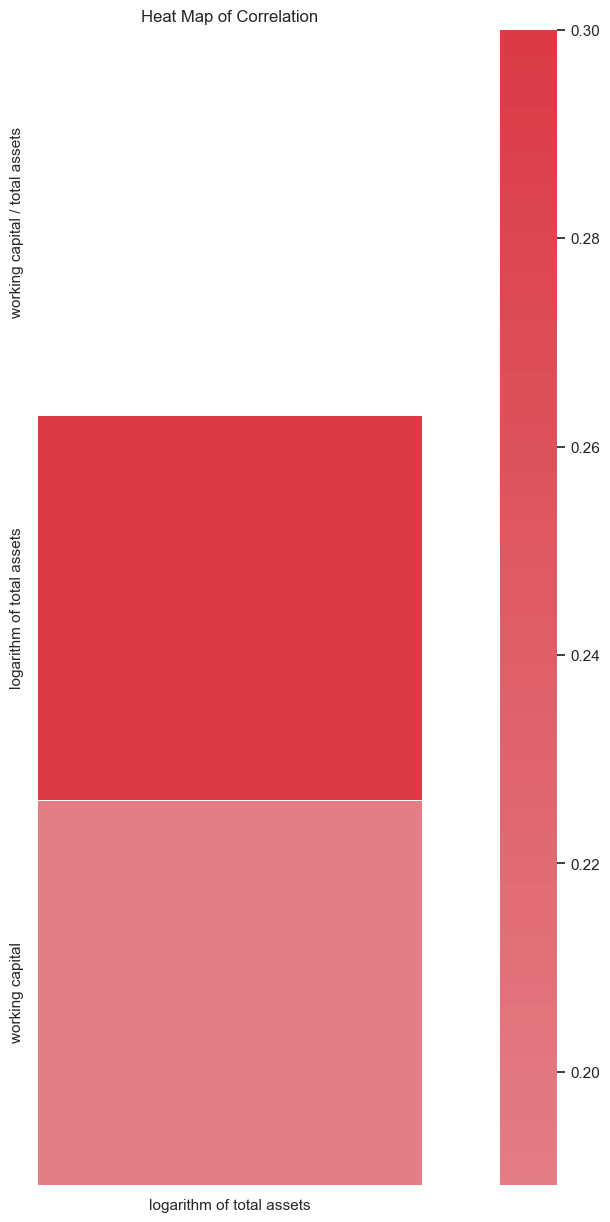

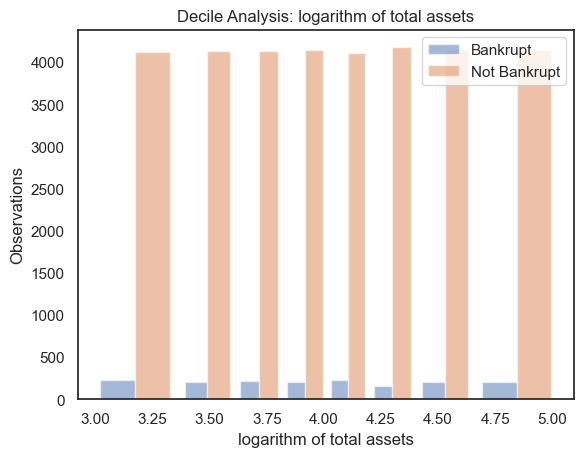

Top 20 Records
      logarithm of total assets  BANKRUPTCY_FLAG
9759                       7.14                0
5244                       7.16                0
376                        7.17                0
6517                       7.18                0
8962                       7.21                0
267                        7.22                0
9043                       7.30                0
5302                       7.47                0
297                        7.50                0
408                        7.51                0
415                        7.57                0
389                        7.60                0
276                        7.66                0
7117                       7.74                0
6614                       7.74                0
290                        9.39                0
401                        9.46                0
408                        9.62                0
382                        9.65                0
273  

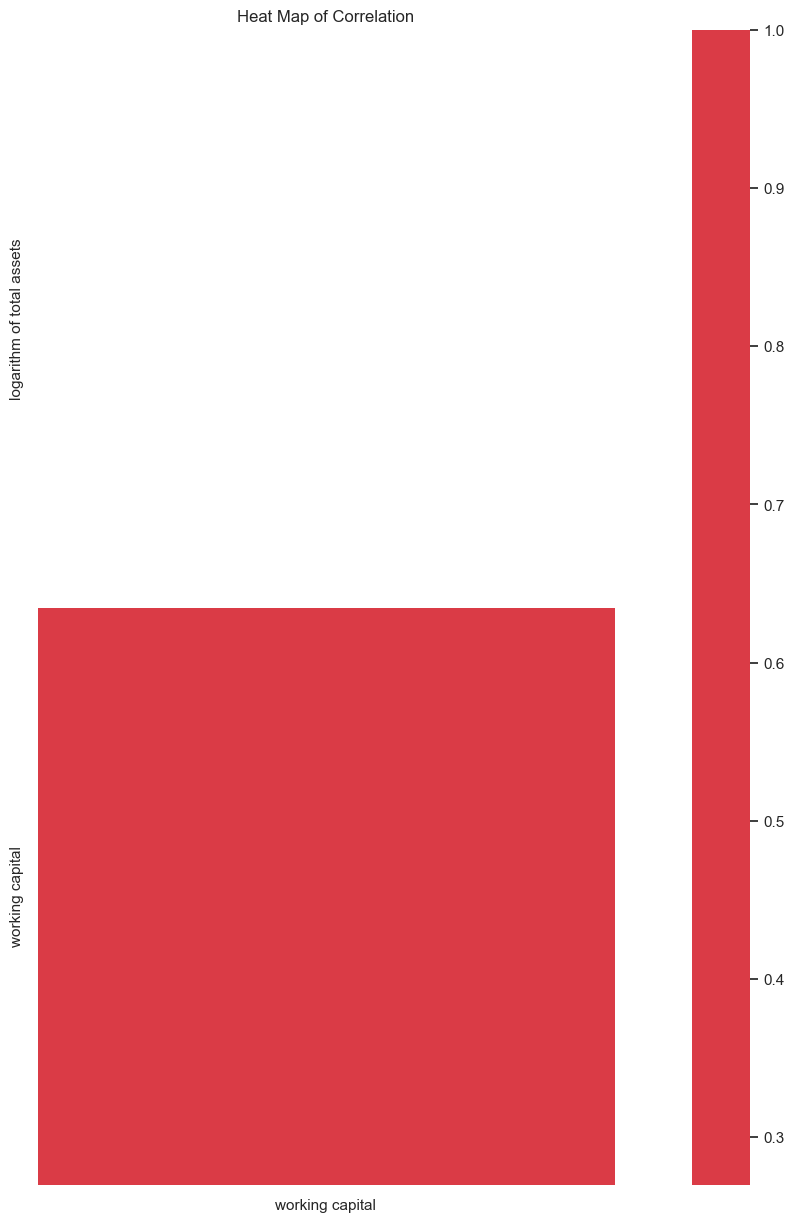

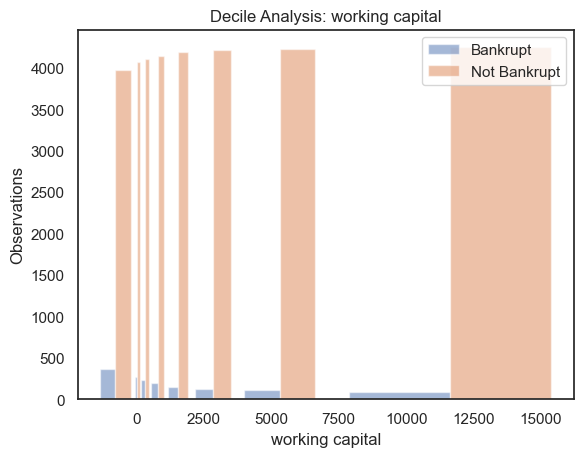

Top 20 Records
      working capital  BANKRUPTCY_FLAG
3869        991610.00                0
2776       1011200.00                0
1701       1016000.00                0
5769       1076400.00                0
5794       1108900.00                0
3881       1139900.00                0
6398       1174500.00                0
1749       1273500.00                0
3730       1345600.00                0
5959       1355800.00                0
2567       1406500.00                0
1593       1634200.00                0
315        2152200.00                0
9670       2653200.00                0
428        3178000.00                0
435        3380500.00                0
9460       3657400.00                0
5244       4212200.00                0
6517       4398400.00                0
8962       6123700.00                0
Bottom 20 Records
      working capital  BANKRUPTCY_FLAG
5947      -1805200.00                0
3674      -1118500.00                0
8723       -937480.00          

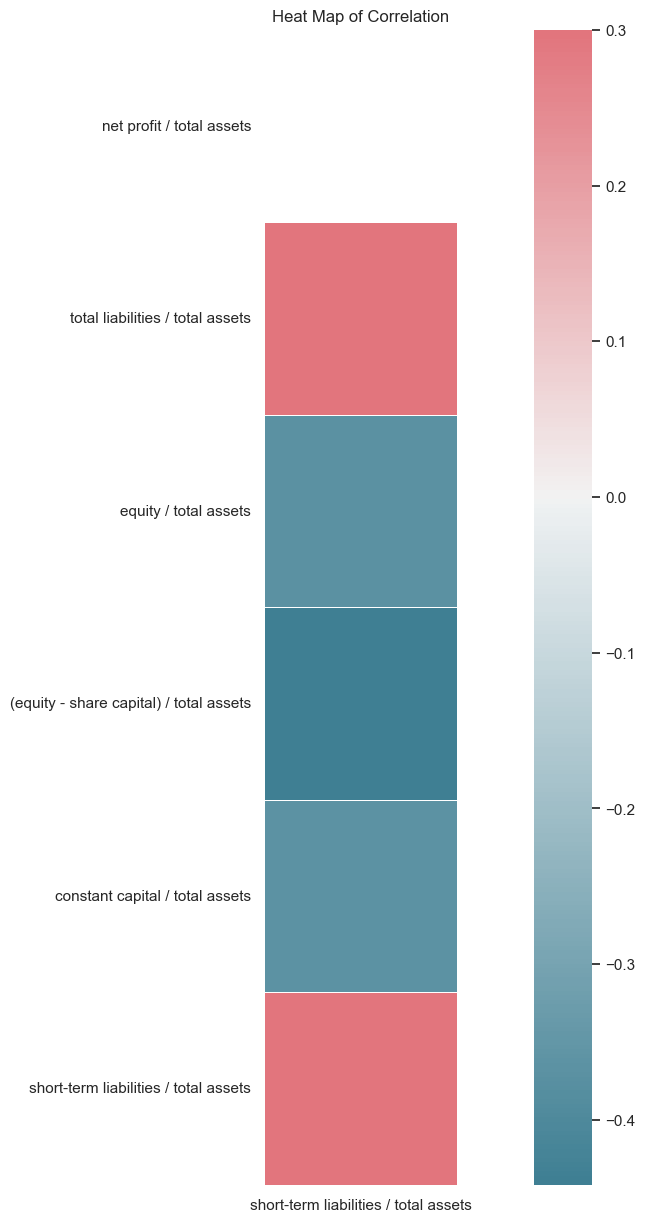

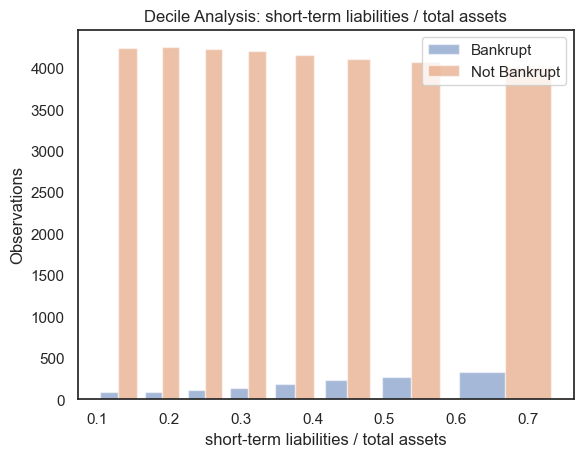

Top 20 Records
       short-term liabilities / total assets  BANKRUPTCY_FLAG
5087                                   14.54                0
9662                                   15.02                1
7776                                   15.72                0
5259                                   16.49                0
1499                                   16.67                0
5001                                   20.40                0
3466                                   21.26                0
1497                                   24.91                0
1392                                   25.43                0
1672                                   25.64                0
1456                                   46.91                0
8242                                   54.23                0
5613                                   72.42                1
5323                                  110.69                0
6921                                  441.50           

Empty DataFrame
Columns: []
Index: [net profit / total assets, total liabilities / total assets, working capital / total assets, current assets / short-term liabilities, [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365, retained earnings / total assets, EBIT / total assets, book value of equity / total liabilities, sales / total assets, equity / total assets, (gross profit + extraordinary items + financial expenses) / total assets, gross profit / short-term liabilities, (gross profit + depreciation) / sales, (gross profit + interest) / total assets, (total liabilities * 365) / (gross profit + depreciation), (gross profit + depreciation) / total liabilities, total assets / total liabilities, gross profit / total assets, gross profit / sales, (inventory * 365) / sales, sales (n) / sales (n-1), profit on operating activities / total assets, net profit / sales, gross profit (in 3 years) / total assets, (equity - share capital) / total assets, (net profit + depreciation) / total liabilities, profit on operating activities / financial expenses, working capital / fixed assets, logarithm of total assets, (total liabilities - cash) / sales, (gross profit + interest) / sales, (current liabilities * 365) / cost of products sold, operating expenses / short-term liabilities, operating expenses / total liabilities, profit on sales / total assets, total sales / total assets, (current assets - inventories) / long-term liabilities, constant capital / total assets, profit on sales / sales, (current assets - inventory - receivables) / short-term liabilities, total liabilities / ((profit on operating activities + depreciation) * (12/365)), profit on operating activities / sales, rotation receivables + inventory turnover in days, (receivables * 365) / sales, net profit / inventory, (current assets - inventory) / short-term liabilities, (inventory * 365) / cost of products sold, EBITDA (profit on operating activities - depreciation) / total assets, EBITDA (profit on operating activities - depreciation) / sales, current assets / total liabilities, short-term liabilities / total assets, (short-term liabilities * 365) / cost of products sold), equity / fixed assets, constant capital / fixed assets, working capital, (sales - cost of products sold) / sales, (current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation), total costs /total sales, long-term liabilities / equity, sales / inventory, sales / receivables, (short-term liabilities *365) / sales, sales / short-term liabilities, sales / fixed assets, BANKRUPTCY_FLAG, dataset, remove_reason, logarithim of working capital]

[68 rows x 0 columns]

In [15]:
# Review Variable - Function which utilizes previously identifed views of data, allowing to focus on one particular element

# The below reviews were completed and decisions, and decisions to clean data embedded directly into 
# function data_cleaning, which is applied to the data

# variable_review(df,'net profit / total assets',og_columns,column_inclusion_review_df)
# variable_review(df,'total liabilities / total assets',og_columns,column_inclusion_review_df)
# variable_review(df,'working capital / total assets',og_columns,column_inclusion_review_df)
# variable_review(df,'retained earnings / total assets',og_columns,column_inclusion_review_df)
# variable_review(df,'logarithm of total assets',og_columns,column_inclusion_review_df)
# variable_review(df,'working capital',og_columns,column_inclusion_review_df)
# variable_review(df,'short-term liabilities / total assets',og_columns,column_inclusion_review_df)


# Utilize Function to clean Dataframe
clean_df,df1 = data_cleaning(df,remove_records=1,clean_records=1)


# Update column_inclusion_review_df with Cleaned Information
column_inclusion_review_df = create_column_inclusion_review(clean_df,
                                                            og_columns,
                                                            column_type_df,
                                                            decile_value_df)

# Review Other Tier 1, Given inclusion of above, these will be already Cleaned
# If looking to replicate original review, utilize df, opposed to clean_df

variable_review(clean_df,'total liabilities / total assets',og_columns,column_inclusion_review_df)
variable_review(clean_df,'working capital / total assets',og_columns,column_inclusion_review_df)
variable_review(clean_df,'retained earnings / total assets',og_columns,column_inclusion_review_df)
variable_review(clean_df,'logarithm of total assets',og_columns,column_inclusion_review_df)
variable_review(clean_df,'working capital',og_columns,column_inclusion_review_df)
variable_review(clean_df,'short-term liabilities / total assets',og_columns,column_inclusion_review_df)

# Utilize Cleaned Dataframe

## Finalize Column By Column Review of all other elements for potential Inclusion

In [16]:
# included_variables = tier1.copy()
# included_variables.append('EBIT / total assets')

# for i in clean_df.columns:
#     if i in included_variables:
#         pass
#     elif i in ['current assets / short-term liabilities',
#                '[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365',
#               'book value of equity / total liabilities',
#                'equity / total assets',
#                'sales / total assets']:
#         pass
#     else:
#         test = review_single_variable_manully(clean_df,
#                                               i,
#                                               tier1,
#                                               column_inclusion_review_df,
#                                               og_columns,
#                                               export_to_excel=1)
        
#         if len(test[test['Baseline V2 Model Inclusion']=='include'])>0:
#             included_variables.append(test['Financial Ratio'].item())
            
            
# test = review_single_variable_manully(clean_df,
#                                '[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365',
#                                tier1,
#                                column_inclusion_review_df,
#                                og_columns,
#                                export_to_excel=1)

# reviewed_variables = read_files_in_folder('/Users/derekdewald/Documents/School/DATASCI207/Project/manual_review','xlsx',1)
# reviewed_variables

In [16]:
clean_df = create_binary_baseline_reference(clean_df)
project_reference_dictionary['Step 3. Clean Data'] =  "Complete on Tier 1 Data"
clean_df

net profit / total assets  total liabilities / total assets  \
0                          0.20                              0.47   
1                          0.03                              0.60   
2                          0.26                              0.30   
3                          0.23                              0.68   
4                          0.09                              0.38   
...                         ...                               ...   
7022                       0.02                              0.47   
7023                       0.00                              0.58   
7024                       0.01                              0.50   
7025                       0.00                              0.85   
7026                       0.01                              0.95   

      working capital / total assets  current assets / short-term liabilities  \
0                               0.24                                     1.52   
1                               0.19                                     1.34   
2                               0.67                                     3.22   
3                               0.04                                     1.08   
4                               0.36                                     1.94   
...                              ...                                      ...   
7022                            0.00                                     0.61   
7023                            0.00                                     0.93   
7024                            0.44                                     1.87   
7025                            0.00                                     0.57   
7026                            0.03                                     1.04   

      [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365  \
0                                                -14.55                                                                     
1                                                -37.86                                                                     
2                                                 71.80                                                                     
3                                                -88.21                                                                     
4                                                 21.73                                                                     
...                                                 ...                                                                     
7022                                             -18.45                                                                     
7023                                             -42.23                                                                     
7024                                               9.74                                                                     
7025                                            -121.92                                                                     
7026                                             -20.58                                                                     

      retained earnings / total assets  EBIT / total assets  \
0                                 0.51                 0.25   
1                                 0.00                 0.04   
2                                 0.00                 0.32   
3                                 0.00                 0.29   
4                                 0.19                 0.11   
...                                ...                  ...   
7022                              0.02                 0.02   
7023                              0.00                -0.02   
7024                              0.01                 0.01   
7025                              0.00                -0.04   
7026      

## Create Baseline Models Using Tier 1 Variables

In [17]:
binary_columns = ['NOT_PROFITABLE', 'NO_LIQUIDITY','LIABILITIES_GT_ASSETS','ST_OBLIGATIONS_GT_TOTAL_ASSETS','NO_EQUITY']
binary_columns_label = ['NOT_PROFITABLE', 'NO_LIQUIDITY','LIABILITIES_GT_ASSETS','ST_OBLIGATIONS_GT_TOTAL_ASSETS','NO_EQUITY','BANKRUPTCY_FLAG']

baseline_columns = ['NOT_PROFITABLE', 'NO_LIQUIDITY','LIABILITIES_GT_ASSETS','ST_OBLIGATIONS_GT_TOTAL_ASSETS',
                    'NO_EQUITY','TWO_BINARY_FLAGS','THREE_BINARY_FLAGS','FOUR_BINARY_FLAGS','FIVE_BINARY_FLAGS',
                    'ALWAYS_BANKRUPT','NEVER_BANKRUPT']

baseline_columns_label = ['NOT_PROFITABLE', 'NO_LIQUIDITY','LIABILITIES_GT_ASSETS','ST_OBLIGATIONS_GT_TOTAL_ASSETS',
                          'NO_EQUITY','TWO_BINARY_FLAGS','THREE_BINARY_FLAGS','FOUR_BINARY_FLAGS','FIVE_BINARY_FLAGS',
                          'ALWAYS_BANKRUPT','NEVER_BANKRUPT','BANKRUPTCY_FLAG']
    
baseline_df = generate_baseline_analysis(clean_df[baseline_columns_label])
#baseline_df.T.to_excel('baseline_df.xlsx')
baseline_df.T

1) Predictions  \
Prediction 0: NOT_PROFITABLE                        43396.00   
Prediction 1: NO_LIQUIDITY                          43396.00   
Prediction 2: LIABILITIES_GT_ASSETS                 43396.00   
Prediction 3: ST_OBLIGATIONS_GT_TOTAL_ASSETS        43396.00   
Prediction 4: NO_EQUITY                             43396.00   
Prediction 5: TWO_BINARY_FLAGS                      43396.00   
Prediction 6: THREE_BINARY_FLAGS                    43396.00   
Prediction 7: FOUR_BINARY_FLAGS                     43396.00   
Prediction 8: FIVE_BINARY_FLAGS                     43396.00   
Prediction 9: ALWAYS_BANKRUPT                       43396.00   
Prediction 10: NEVER_BANKRUPT                       43396.00   

                                              2) Bankrupties Predicted  \
Prediction 0: NOT_PROFITABLE                                   9531.00   
Prediction 1: NO_LIQUIDITY                                     9612.00   
Prediction 2: LIABILITIES_GT_ASSETS                            2277.00   
Prediction 3: ST_OBLIGATIONS_GT_TOTAL_ASSETS                   1409.00   
Prediction 4: NO_EQUITY                                       27656.00   
Prediction 5: TWO_BINARY_FLAGS                                 7533.00   
Prediction 6: THREE_BINARY_FLAGS                               2688.00   
Prediction 7: FOUR_BINARY_FLAGS                                 730.00   
Prediction 8: FIVE_BINARY_FLAGS                                1013.00   
Prediction 9: ALWAYS_BANKRUPT                                 43396.00   
Prediction 10: NEVER_BANKRUPT                                     0.00   

                                              3) True Positives  \
Prediction 0: NOT_PROFITABLE                             958.00   
Prediction 1: NO_LIQUIDITY                               903.00   
Prediction 2: LIABILITIES_GT_ASSETS                      307.00   
Prediction 3: ST_OBLIGATIONS_GT_TOTAL_ASSETS             228.00   
Prediction 4: NO_EQUITY                                 1575.00   
Prediction 5: TWO_BINARY_FLAGS                           539.00   
Prediction 6: THREE_BINARY_FLAGS                         350.00   
Prediction 7: FOUR_BINARY_FLAGS                           71.00   
Prediction 8: FIVE_BINARY_FLAGS                          179.00   
Prediction 9: ALWAYS_BANKRUPT                           2090.00   
Prediction 10: NEVER_BANKRUPT                              0.00   

                                              4) True Negatives  \
Prediction 0: NOT_PROFITABLE                           32733.00   
Prediction 1: NO_LIQUIDITY                             32597.00   
Prediction 2: LIABILITIES_GT_ASSETS                    39336.00   
Prediction 3: ST_OBLIGATIONS_GT_TOTAL_ASSETS           40125.00   
Prediction 4: NO_EQUITY                                15225.00   
Prediction 5: TWO_BINARY_FLAGS                         34312.00   
Prediction 6: THREE_BINARY_FLAGS                       38968.00   
Prediction 7: FOUR_BINARY_FLAGS                        40647.00   
Prediction 8: FIVE_BINARY_FLAGS                        40472.00   
Prediction 9: ALWAYS_BANKRUPT                              0.00   
Prediction 10: NEVER_BANKRUPT                          41306.00   

                                              5) False Positives  \
Prediction 0: NOT_PROFITABLE                             8573.00   
Prediction 1: NO_LIQUIDITY                               8709.00   
Prediction 2: LIABILITIES_GT_ASSETS                      1970.00   
Prediction 3: ST_OBLIGATIONS_GT_TOTAL_ASSETS             1181.00   
Prediction 4: NO_EQUITY                                 26081.00   
Prediction 5: TWO_BINARY_FLAGS                           6994.00   
Prediction 6: THREE_BINARY_FLAGS                         2338.00   
Prediction 7: FOUR_BINARY_FLAGS                           659.00   
Prediction 8: FIVE_BINARY_FLAGS                           834.00   
Prediction 9: ALWAYS_BANKRUPT                           41306.00   
Prediction 10: NEVER_BANKRUPT 

### How can we interpret our Baseline?

1. While we can generate models with very higher Accuracy 95%+, are these models helpful? Pragmatically, a model which simply predict nothing will be bankrupt is unlikely to be helpful, if we think about the individuals who are most likely to be interested in purchasing our model (Banks, Loan Origination companies, Venture capital firms) and how they would use these models, run a model against a perpsective customer seeking financing. While they want to issue the loans to the maximium number of companies (maximize profit on their available capital), they do not want to issue any loans to customers who will go bankrupt (this represents a loss in capital) and they want to price the loans based on a risk adjusted basis, so the more accurate they understand risk, the better their risk adjusted return will be.
    
2. We have identified a Tier 1 Ratio Model, in looking at our Financial Ratio Definitions, we can see that our tier 1 model possess some seemingly desirable attributes, 1) It has coverage of 3 types of ratios (It does not have Turnover, however Turnover ratios apply primarily to manufacturing and retail sales companies, as discussed in variable review, we have no belief that this represents a majority of companies in our index ( we don't know composition, thus can leave it out). 

3. Given this baseline, we can generate 3 distinct datasets:
    1. All of the columns in original dataset ( we have spoken to limitation, but given ease to test, we can
    review).
    2. Tier 1 Columns
    3. Tier 1 Columns as Binary Approximations (per baseline review)


In [18]:
# Update Project Reference Dictionary
project_reference_dictionary['Step 4. Determine which Data to Include'] = '3 Proposed Datasets for Testing'
project_reference_dictionary['Step 5. Identify a Baseline'] = 'Completed'

# Add thought to reference column for consideration
project_reference_dictionary['Inclusion'] = ['Can we include some type of ROI ideology, such that investors can define model acceptance, and how that impacts model, perhaps demostrate how that might impact profitability']

## Create Models

In [20]:

def knn_model_creation(X_df,
                       y_df,
                       neighbors=3):    
    model = KNeighborsClassifier(n_neighbors=neighbors)
    model.fit(X_df,y_df)    
    return model

def logistic_regression_creation(X_df,
                                 y_df,
                                 max_iter=100,
                                 solver='liblinear'):
    '''
    
    
    for i in [10,20,30]:
        temp_df = (y_probabilities >= i/100).astype(int)
        knn_df = pd.concat([knn_df,pd.DataFrame(temp_df,columns=[f'LR_{str(i)}p'])],axis=1)
        
        
    '''
    model = LogisticRegression(solver='liblinear',max_iter=max_iter)
    model.fit(X_df,y_df)
    return model


def random_forest_classifier(X_df,
                             y_df):
    '''
    important_features_rf = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
    
    '''
    model = RandomForestClassifier()
    model.fit(X_df,y_df)
    return model

def neural_network(X_df,
                   y_df,
                   input_dim, 
                   hidden_layer_sizes,
                   activation,
                   optimizer,
                   learning_rate,
                   epochs,
                   batch_size,
                   metrics,
                   verbose=0):

    """Build a binary classification model using Keras.

      Args:
        input_dim: Number of features in the input data.
        hidden_layer_sizes: A list with the number of units in each hidden layer.
        activation: The activation function to use for the hidden layers.
        optimizer: The optimizer
        learning_rate: The desired learning rate for the optimizer.

      Returns:
        model: A tf.keras model.
    """
    # Instantiate Model
    model = keras.models.Sequential()

    # Add Input Layer
    model.add(layers.InputLayer(input_shape=(input_dim,)))

    # Add Hidden Layers
    for nodes in hidden_layer_sizes:
        model.add(layers.Dense(units=nodes, activation=activation))

    # Add Output Layer
    model.add(layers.Dense(units=1, activation='sigmoid'))

    # Configure optimizer and compile the model
    if optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

    history = model.fit(x=X_df,
                        y=y_df,
                        batch_size=batch_size,
                        epochs=epochs)
    
    return model,history

In [19]:
def create_model(X_df,
                 y_df,
                 model_parameters={},
                 metrics=['accuracy', keras.metrics.Precision(),keras.metrics.Recall()]):
    '''
    
    Function to generate ML Model, based on model type as defined in Parameters.
    Below values for illustration purposes, can utilize dictionary to update as desired.

    if model is neural_network, 
    model_parameters = {'hidden_layer_sizes':[8,16,32,64],
                                          'activation':'relu',
                                          'optimizer':'adam',
                                          'learning_rate':.05,
                                          'prediction_name':''}
    if model Logistic Regression,
    model_parameters = {'solver':'liblinear','max_iter':200,'prediction_name':''}

    if model knn,
    model_parameters = {'n_neighbors':3,'prediction_name':''}

    if model random_forsest
    model_parameters={'prediction_name':''}

    '''

    if model_parameters['model'] == 'neural_network':
        model = neural_network(X_df,
                               y_df,
                               input_dim=len(X_df.columns.values), 
                               hidden_layer_sizes= model_parameters['hidden_layer_sizes'],
                               activation=model_parameters['activation_function'], 
                               optimizer=model_parameters['optimizer'],
                               learning_rate=model_parameters['learning_rate'],
                               batch_size=int(model_parameters['batch_size']),
                               epochs=int(model_parameters['num_epochs']),
                               metrics=metrics)

    elif model_parameters['model'] == 'logistic_regression':
        model = logistic_regression_creation(X_df,
                                             y_df,
                                             max_iter=int(model_parameters['max_iter']),
                                             solver=model_parameters['solver'])
    elif model_parameters['model'] == 'random_forest':
        model = random_forest_classifier(X_df,
                                         y_df)
    elif model_parameters['model'] == 'knn':
        model = knn_model_creation(X_df,
                                   y_df,
                                   neighbors=int(model_parameters['n_neighbors']))
    return model

def generate_predicition(X_test_df,
                         y_test_df,
                         py_model,
                         model_parameters):

    if model_parameters['model'] == 'neural_network':        
        predict_prob = py_model[0].predict(X_test_df)
        pred_df = pd.DataFrame((predict_prob >= model_parameters['decision_boundary']).astype(int),columns=[model_parameters['prediction_name']])
        pred_df = pd.concat([y_test_df.reset_index(drop=True),pred_df],axis=1)

        model_final_results_df = generate_baseline_analysis(pred_df)
        
        model_final_results_df.loc['10) Dataset'] = model_parameters['prediction_name']
        model_final_results_df.loc['11) activation'] = model_parameters['activation_function']
        model_final_results_df.loc['12) optimizer'] = model_parameters['optimizer']
        model_final_results_df.loc['13) learning_rate'] = model_parameters['learning_rate']
        model_final_results_df.loc['14) batch_size'] = model_parameters['batch_size']
        model_final_results_df.loc['15) epochs'] = model_parameters['num_epochs']
        model_final_results_df.loc['16) hidden_layer_sizes'] = text_manipulation(model_parameters['hidden_layer_sizes'])

        acc = pd.DataFrame(py_model[1].history['accuracy'],columns=["Training Accuracy"])
        loss = pd.DataFrame(py_model[1].history['loss'],columns=["Training Loss"])
        prec_str = columns=[x for x in py_model[1].history.keys() if x.find('pre')!=-1][0]
        recall_str = columns=[x for x in py_model[1].history.keys() if x.find('reca')!=-1][0]
        precision = pd.DataFrame(py_model[1].history[prec_str],columns=[prec_str]).rename(columns={prec_str:'Precision'})
        recall = pd.DataFrame(py_model[1].history[recall_str],columns=[recall_str]).rename(columns={recall_str:'Recall'})
        model_results_df = pd.concat([pd.DataFrame(range(0,10),columns=['Number of Epochs']),acc,loss,precision,recall],axis=1)
        
        model_results_df['Dataset'] = model_parameters['prediction_name']
        model_results_df['Model'] = model_parameters['model']
        model_results_df['activation'] = model_parameters['activation_function']
        model_results_df['optimizer'] = model_parameters['optimizer']
        model_results_df['learning_rate'] = model_parameters['learning_rate']
        model_results_df['batch_size'] = model_parameters['batch_size']
        model_results_df['epochs'] = model_parameters['num_epochs']
        model_results_df['hidden_layer_sizes'] = text_manipulation(model_parameters['hidden_layer_sizes'])
        
        #model_results_df['bankrupt_observations'] = bankrupcy_observations
        #model_results_df['total_observations_read'] = len(X)
        
        return pred_df,model_results_df,model_final_results_df
    
    elif model_parameters['model'] =='knn':
        pred = py_model.predict(X_test_df)
        pred_df = pd.DataFrame(pred,columns=[model_parameters['prediction_name']])
        label_and_pred_df = pd.concat([y_test_df.reset_index(drop=True),pred_df],axis=1)

        model_results = generate_baseline_analysis(label_and_pred_df)
        model_results.loc['17) N_Neighors'] = model_parameters['n_neighbors']

    elif model_parameters['model']=='random_forest':
        pred = py_model.predict(X_test_df)
        pred_df = pd.DataFrame(pred,columns=[model_parameters['prediction_name']])
        label_and_pred_df = pd.concat([y_test_df.reset_index(drop=True),pred_df],axis=1)

        model_results = generate_baseline_analysis(label_and_pred_df)

    elif model_parameters['model']=='logistic_regression':
        pred = py_model.predict(X_test_df)
        pred_df = pd.DataFrame(pred,columns=[model_parameters['prediction_name']])
        label_and_pred_df = pd.concat([y_test_df.reset_index(drop=True),pred_df],axis=1)

        model_results = generate_baseline_analysis(label_and_pred_df)
        model_results.loc['18) Solver'] = model_parameters['solver']
        model_results.loc['19) Max Iterations'] = model_parameters['max_iter']
        
    return label_and_pred_df,model_results

## Create Data Pipeline

In [20]:
def single_model_test(X_train,
                      y_train,
                      X_test,
                      y_test,
                      scale_type,
                      model_parameters,
                      test_size=0.3):
    
    '''

    
    
    '''

    if scale_type.lower() == 'standard_scalar':
        X = apply_standard_scaler(X_train,X_train.columns.values)
    elif scale_type.lower()=='min_max':
        X = apply_min_max_scaler(X_train,X_train.columns.values)
    
    py_model  = create_model(X_train,
                         y_train,
                         model_parameters=model_parameters)

    output = generate_predicition(X_test_df=X_test,
                                          y_test_df=y_test,
                                          py_model=py_model,
                                          model_parameters=model_parameters)


    return output

In [21]:
def run_evaluation_pipeline(datasets,
                            scalar,
                            balance_bankrupcy_observations,
                            model_iterations,
                            validation_percentage=.3,
                           ):

    final_prediction = pd.DataFrame()
    final_results = pd.DataFrame()

    # Iterate through datasets
    for population in datasets.keys():
        if population != 'labels':
            X= dataset_dictionary[population]
            y=dataset_dictionary['labels']
            X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=validation_percentage, random_state=15)
  
            # Given Dataset is Unbalanced Need to Clean it Up
            
            for number_obs_to_retain in balance_bankrupcy_observations:
                if number_obs_to_retain == 0:
                    X_train1 = X_train.copy()
                    y_train1 = y_train.copy()
                else:
                    temp_df = pd.concat([X_train1,y_train1],axis=1)
                    bankrupt_obs = sum(temp_df['BANKRUPTCY_FLAG']) 
                    temp_df = pd.concat([temp_df[temp_df['BANKRUPTCY_FLAG']==1].sample(min(bankrupt_obs,number_obs_to_retain)),
                                         temp_df[temp_df['BANKRUPTCY_FLAG']==0].sample(min(bankrupt_obs,number_obs_to_retain))])
                    X_train1 = temp_df.drop('BANKRUPTCY_FLAG',axis=1).copy()
                    y_train1 = temp_df[['BANKRUPTCY_FLAG']]
                
            for scaler in standardizations:
                if scaler.lower() == 'min_max':
                    X_train,scaler = apply_standard_scaler(X_train)
                    X_test1 = scaler.transform(X_test)
                elif scaler.lower()=='min_max':
                    X_train,scaler = apply_min_max_scaler(X_train)
                    X_test1 = scaler.transform(X_test)
                else:
                    X_test1 = X_test.copy()

            for parameter_instance in range(len(model_iterations)):
                model_parameters = dict(model_iterations.iloc[parameter_instance][model_iterations.iloc[parameter_instance]!=""])
                # Run function

                print(model_parameters)
                
                py_model  = create_model(X_train1,
                                         y_train1,
                                         model_parameters=model_parameters)

                output = generate_predicition(X_test_df=X_test1,
                                              y_test_df=y_test,
                                              py_model=py_model,
                                              model_parameters=model_parameters)
                
                final_prediction = pd.concat([final_prediction,output[0].drop('BANKRUPTCY_FLAG',axis=1)],axis=1)
                final_results = pd.concat([final_results,output[1].T])
                                                               
    return final_prediction,final_results

## Generate Information Required to Run Model

In [24]:
dataset_dictionary= {'All Ratios Cleaned':clean_df[og_predict_columns].fillna(0),
                     'Tier 1 Ratios, Actual Values':clean_df[tier1],
                     'Tier 1 Ratios, Binary Approximations':clean_df[binary_columns],
                     'labels':clean_df['BANKRUPTCY_FLAG']}

# Create Dictionary of Values to Iterate through Models to Determine Performance


datasets = ['All Ratios Cleaned','Tier 1 Ratios, Actual Values','Tier 1 Ratios, Binary Approximations']
standardizations = ['none','min_max','standard_scalar']
perc_bankrupcy_obs = [0,1000,1500]

nn_model_review_params = {
    'model':['neural_network'],
    'activation_function': ['relu', 'tanh', 'sigmoid'],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.01, 0.05],
    'batch_size': [100,1000],
    'num_epochs': [ 10, 20],
    'hidden_layer_sizes':[[8],[8,16],[8,16,32],[8,16,32,64]],
    'validation_split': [0.3],
    'decision_boundary':[20,30,40,50],
    'metrics':['accuracy', keras.metrics.Precision(),keras.metrics.Recall()]
}

knn_model_review_params = {
    'model':['knn'],
    'n_neighbors': range(2,11,2)
}

logistic_regression_model_review_params = {
    'model':['logistic_regression'],
    'solver':['liblinear','newton-cg','lbfgs','sag','saga'],
    'max_iter':[250],
    'decision_boundary':[20,30,40,50]
}

random_forest_model_review_params = {
    'model':['random_forest']
}

model_iterations =  create_df_models_to_test([nn_model_review_params,
                                              knn_model_review_params,
                                              logistic_regression_model_review_params,
                                              random_forest_model_review_params])


pipeline_results = run_evaluation_pipeline(datasets= dataset_dictionary,
                                  scalar=standardizations,
                                  balance_bankrupcy_observations=[0,1000,1500],
                                  model_iterations=model_iterations)
                        
pipeline_results

{'model': 'knn', 'n_neighbors': 2.0, 'prediction_name': 'knn1'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

{'model': 'knn', 'n_neighbors': 4.0, 'prediction_name': 'knn2'}
{'model': 'knn', 'n_neighbors': 6.0, 'prediction_name': 'knn3'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

{'model': 'knn', 'n_neighbors': 8.0, 'prediction_name': 'knn4'}
{'model': 'knn', 'n_neighbors': 10.0, 'prediction_name': 'knn5'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

{'model': 'logistic_regression', 'solver': 'liblinear', 'max_iter': 250.0, 'decision_boundary': 20.0, 'prediction_name': 'logistic_regression1'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

{'model': 'logistic_regression', 'solver': 'liblinear', 'max_iter': 250.0, 'decision_boundary': 30.0, 'prediction_name': 'logistic_regression2'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'liblinear', 'max_iter': 250.0, 'decision_boundary': 40.0, 'prediction_name': 'logistic_regression3'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'liblinear', 'max_iter': 250.0, 'decision_boundary': 50.0, 'prediction_name': 'logistic_regression4'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'newton-cg', 'max_iter': 250.0, 'decision_boundary': 20.0, 'prediction_name': 'logistic_regression5'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'newton-cg', 'max_iter': 250.0, 'decision_boundary': 30.0, 'prediction_name': 'logistic_regression6'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'newton-cg', 'max_iter': 250.0, 'decision_boundary': 40.0, 'prediction_name': 'logistic_regression7'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'newton-cg', 'max_iter': 250.0, 'decision_boundary': 50.0, 'prediction_name': 'logistic_regression8'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'lbfgs', 'max_iter': 250.0, 'decision_boundary': 20.0, 'prediction_name': 'logistic_regression9'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'lbfgs', 'max_iter': 250.0, 'decision_boundary': 30.0, 'prediction_name': 'logistic_regression10'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'lbfgs', 'max_iter': 250.0, 'decision_boundary': 40.0, 'prediction_name': 'logistic_regression11'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'lbfgs', 'max_iter': 250.0, 'decision_boundary': 50.0, 'prediction_name': 'logistic_regression12'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'sag', 'max_iter': 250.0, 'decision_boundary': 20.0, 'prediction_name': 'logistic_regression13'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'sag', 'max_iter': 250.0, 'decision_boundary': 30.0, 'prediction_name': 'logistic_regression14'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'sag', 'max_iter': 250.0, 'decision_boundary': 40.0, 'prediction_name': 'logistic_regression15'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'sag', 'max_iter': 250.0, 'decision_boundary': 50.0, 'prediction_name': 'logistic_regression16'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'saga', 'max_iter': 250.0, 'decision_boundary': 20.0, 'prediction_name': 'logistic_regression17'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'saga', 'max_iter': 250.0, 'decision_boundary': 30.0, 'prediction_name': 'logistic_regression18'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'saga', 'max_iter': 250.0, 'decision_boundary': 40.0, 'prediction_name': 'logistic_regression19'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'logistic_regression', 'solver': 'saga', 'max_iter': 250.0, 'decision_boundary': 50.0, 'prediction_name': 'logistic_regression20'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_a

{'model': 'random_forest', 'prediction_name': 'random_forest1'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

{'model': 'knn', 'n_neighbors': 2.0, 'prediction_name': 'knn1'}
{'model': 'knn', 'n_neighbors': 4.0, 'prediction_name': 'knn2'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

{'model': 'knn', 'n_neighbors': 6.0, 'prediction_name': 'knn3'}
{'model': 'knn', 'n_neighbors': 8.0, 'prediction_name': 'knn4'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

{'model': 'knn', 'n_neighbors': 10.0, 'prediction_name': 'knn5'}
{'model': 'logistic_regression', 'solver': 'liblinear', 'max_iter': 250.0, 'decision_boundary': 20.0, 'prediction_name': 'logistic_regression1'}
{'model': 'logistic_regression', 'solver': 'liblinear', 'max_iter': 250.0, 'decision_boundary': 30.0, 'prediction_name': 'logistic_regression2'}
{'model': 'logistic_regression', 'solver': 'liblinear', 'max_iter': 250.0, 'decision_boundary': 40.0, 'prediction_name': 'logistic_regression3'}
{'model': 'logistic_regression', 'solver': 'liblinear', 'max_iter': 250.0, 'decision_boundary': 50.0, 'prediction_name': 'logistic_regression4'}
{'model': 'logistic_regression', 'solver': 'newton-cg', 'max_iter': 250.0, 'decision_boundary': 20.0, 'prediction_name': 'logistic_regression5'}
{'model': 'logistic_regression', 'solver': 'newton-cg', 'max_iter': 250.0, 'decision_boundary': 30.0, 'prediction_name': 'logistic_regression6'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

{'model': 'logistic_regression', 'solver': 'newton-cg', 'max_iter': 250.0, 'decision_boundary': 40.0, 'prediction_name': 'logistic_regression7'}
{'model': 'logistic_regression', 'solver': 'newton-cg', 'max_iter': 250.0, 'decision_boundary': 50.0, 'prediction_name': 'logistic_regression8'}
{'model': 'logistic_regression', 'solver': 'lbfgs', 'max_iter': 250.0, 'decision_boundary': 20.0, 'prediction_name': 'logistic_regression9'}
{'model': 'logistic_regression', 'solver': 'lbfgs', 'max_iter': 250.0, 'decision_boundary': 30.0, 'prediction_name': 'logistic_regression10'}
{'model': 'logistic_regression', 'solver': 'lbfgs', 'max_iter': 250.0, 'decision_boundary': 40.0, 'prediction_name': 'logistic_regression11'}
{'model': 'logistic_regression', 'solver': 'lbfgs', 'max_iter': 250.0, 'decision_boundary': 50.0, 'prediction_name': 'logistic_regression12'}
{'model': 'logistic_regression', 'solver': 'sag', 'max_iter': 250.0, 'decision_boundary': 20.0, 'prediction_name': 'logistic_regression13'}
{'m

/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

{'model': 'knn', 'n_neighbors': 2.0, 'prediction_name': 'knn1'}
{'model': 'knn', 'n_neighbors': 4.0, 'prediction_name': 'knn2'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

{'model': 'knn', 'n_neighbors': 6.0, 'prediction_name': 'knn3'}
{'model': 'knn', 'n_neighbors': 8.0, 'prediction_name': 'knn4'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

{'model': 'knn', 'n_neighbors': 10.0, 'prediction_name': 'knn5'}
{'model': 'logistic_regression', 'solver': 'liblinear', 'max_iter': 250.0, 'decision_boundary': 20.0, 'prediction_name': 'logistic_regression1'}
{'model': 'logistic_regression', 'solver': 'liblinear', 'max_iter': 250.0, 'decision_boundary': 30.0, 'prediction_name': 'logistic_regression2'}
{'model': 'logistic_regression', 'solver': 'liblinear', 'max_iter': 250.0, 'decision_boundary': 40.0, 'prediction_name': 'logistic_regression3'}
{'model': 'logistic_regression', 'solver': 'liblinear', 'max_iter': 250.0, 'decision_boundary': 50.0, 'prediction_name': 'logistic_regression4'}
{'model': 'logistic_regression', 'solver': 'newton-cg', 'max_iter': 250.0, 'decision_boundary': 20.0, 'prediction_name': 'logistic_regression5'}


/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

{'model': 'logistic_regression', 'solver': 'newton-cg', 'max_iter': 250.0, 'decision_boundary': 30.0, 'prediction_name': 'logistic_regression6'}
{'model': 'logistic_regression', 'solver': 'newton-cg', 'max_iter': 250.0, 'decision_boundary': 40.0, 'prediction_name': 'logistic_regression7'}
{'model': 'logistic_regression', 'solver': 'newton-cg', 'max_iter': 250.0, 'decision_boundary': 50.0, 'prediction_name': 'logistic_regression8'}
{'model': 'logistic_regression', 'solver': 'lbfgs', 'max_iter': 250.0, 'decision_boundary': 20.0, 'prediction_name': 'logistic_regression9'}
{'model': 'logistic_regression', 'solver': 'lbfgs', 'max_iter': 250.0, 'decision_boundary': 30.0, 'prediction_name': 'logistic_regression10'}
{'model': 'logistic_regression', 'solver': 'lbfgs', 'max_iter': 250.0, 'decision_boundary': 40.0, 'prediction_name': 'logistic_regression11'}
{'model': 'logistic_regression', 'solver': 'lbfgs', 'max_iter': 250.0, 'decision_boundary': 50.0, 'prediction_name': 'logistic_regression12'

/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/derekdewald/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


(       knn1  knn2  knn3  knn4  knn5  logistic_regression1  \
 0         0     0     0     0     0                     0   
 1         0     0     0     0     0                     0   
 2         0     0     0     0     0                     0   
 3         0     0     0     0     0                     0   
 4         0     0     1     1     1                     1   
 ...     ...   ...   ...   ...   ...                   ...   
 13014     0     1     1     1     1                     1   
 13015     1     0     0     0     0                     0   
 13016     1     1     1     1     1                     1   
 13017     0     0     0     0     0                     0   
 13018     0     0     0     0     0                     0   
 
        logistic_regression2  logistic_regression3  logistic_regression4  \
 0                         0                     0                     0   
 1                         0                     0                     0   
 2                        

### Run Model Testing Pipeline

In [ ]:


model_iterations



    


### Run a Single Model

In [30]:
output = single_model_test(X_train,
                           y_train,
                           X_test,
                           y_test,
                           scale_type='none',
                           model_parameters=model_parameters)

NameError: name 'X_train' is not defined

In [ ]:
model_parameters = define_model_parameters(model='logistic_regression',
                                           prediction_name='LR1',
                                           solver='liblinear',
                                           max_iter=250)

# model_parameters = define_model_parameters(model='neural_network',
#                                            prediction_name='neural_network1',
#                                            hidden_layer_sizes=[8,16,32,64],
#                                            activation='relu',
#                                            optimizer='adam',
#                                            learning_rate=.05,
#                                            metrics=['accuracy', keras.metrics.Precision(),keras.metrics.Recall()],
#                                            batch_size=100,
#                                            num_epochs=10,
#                                            decision_boundary=.5)

# model_parameters = define_model_parameters(model='random_forest',
#                                            prediction_name='RF1')


# model_parameters = define_model_parameters(model='knn',
#                                            n_neighbors=1,
#                                            prediction_name='KNN1')



## Create a Data Pipeline to Test Multiple Models

In [ ]:
# Create 3 Dictionaries

# Dictionary 1, Dataset Dictionary. A Dictionary of the datasets which will be used for Model Review, based on
# proposed Comments above. We current have 3 candidates. Potential to Add More.





                                  



# Generate all combinations of options

# nn_selection_list = list(product(*nn_model_review_params.values()))
# knn_selection_list = list(product(*knn_model_review_params.values()))
# lr_selection_list = list(product(*logistic_regression_model_review_params.values()))
# random_forest_list = list(product(*random_forest_model_review_params.values()))

# print(f"Model Selection Records NN: {len(nn_selection_list)}")
# print(f"Model Selection Records KNN: {len(knn_selection_list)}")
# print(f"Model Selection Records LR: {len(lr_selection_list)}")
# print(f"Model Selection Records RF: {len(random_forest_list)}")

# nn_model_tuning_parameters = {
#     'data_standardizations':['none','min_max','standard_scalar'],
#     'ml_model':['neural_network'],
#     'bankrupcy_observations':[100,500,1000,'max','entire_dataset'],
#    'activation_function': ['relu', 'tanh', 'sigmoid'],
#     'optimizer': ['adam', 'sgd'],
#     'learning_rate': [0.001, 0.01, 0.05, 0.1],
#     'batch_size': [10,100,1000],
#     'epochs': [5, 10, 20],
#     'validation_split': [0.1, 0.2, 0.3],
#     'verbose': [0]}

# model_tuning_list = list(product(*nn_model_tuning_parameters.values()))

# print(f"Model Tuning Records: {len(model_tuning_list)}")

In [ ]:



#Step 1  Normalize Data
#Step 2
#Step 3



# Define All Data Sets, defined at Column Level



# Select the Columns
# Select the Records we're to utilize.    
# We need to normalize Data
# We need to Create Training and Testing
# Run Model
# Save Output
    
                               

In [ ]:
temp_df


In [ ]:
model_iterations

## Create Data Pipeline

In [ ]:

model_parameter

# Where am I going to take out the Validation Data.
# Where am I going to do the Standardization of Data?
# Where am I going to take out the testing data.


    # Step 1 Scale Data
if scaling_method.lower() == 'standard_scalar':
    X = apply_standard_scaler(X_df,X_df.columns.values)
elif scaling_method.lower()=='min_max':
    X = apply_min_max_scaler(X_df,X_df.columns.values)

    if bankrupcy_observations == 'entire_dataset':
a        pass
    elif bankrupcy_observations == 'all_bankrupcies':
        X,y = create_balanced_dataset(X,y)
    else:
        X,y = create_balanced_dataset(X,y,bankrupcy_observations)




history.history['accuracy']
history.history['val_accuracy']



plt.figure(figsize=(15,5))
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

## Generate a Single Example to Demonstrate generate Model Functionality

### Visuals Utilized in Slide Deck

In [ ]:
create_decile(df,'net profit / total assets')

In [ ]:
plt.hist(clean_df['net profit / total assets'])
plt.title('Histogram of Net Profit / Total Assets')
plt.xlabel('Company Net Profit / Total Assets')
plt.ylabel('Total Observations')
plt.show()

In [ ]:
column_inclusion_review_df[column_inclusion_review_df['Financial Ratio']=='net profit / total assets'].set_index('Financial Ratio').T


## Code Used While Testing Creation and Functionality

In [ ]:
# model_parameters = define_model_parameters(model='neural_network',
#                                            prediction_name='neural_network1',
#                                            hidden_layer_sizes=[8,16,32,64],
#                                            activation='relu',
#                                            optimizer='adam',
#                                            learning_rate=.05,
#                                            metrics=['accuracy', keras.metrics.Precision(),keras.metrics.Recall()],
#                                            batch_size=100,
#                                            num_epochs=10,
#                                            decision_boundary=.5)
                    
# py_model  = create_model(X_train,
#                          y_train,
#                          model=model,
#                          model_parameters=model_parameters)

# test = generate_predicition(X_test_df=X_test,
#                                           y_test_df=y_test,
#                                           model=model,
#                                           py_model=py_model,
#                                           model_parameters=model_parameters)


# # Parameters 
# model= 'logistic_regression'
# model_parameters = {'solver':'liblinear','max_iter':200,'prediction_name':'Logistic Regression1'}

# # Generate Model
# py_model = create_model(X_train,
#                       y_train,
#                       model=model,
#                       model_parameters=model_parameters)

# # Predict Using Model
# pred_df,results_df = generate_predicition(X_test_df=X_test,
#                                           y_test_df=y_test,
#                                           model=model,
#                                           py_model=py_model,
#                                           model_parameters=model_parameters)
# print(results_df)
# print(pred_df.head())

# # Parameters 
# model= 'knn'
# model_parameters = {'n_neighbors':3,'prediction_name':'KNN_Model1'}

# # Generate Model
# py_model = create_model(X_train,
#                       y_train,
#                       model=model,
#                       model_parameters=model_parameters)

# # Predict Using Model
# pred_df,results_df = generate_predicition(X_test_df=X_test,
#                                           y_test_df=y_test,
#                                           model=model,
#                                           py_model=py_model,
#                                           model_parameters=model_parameters)
# print(results_df)
# print(pred_df.head())

# model='random_forest'
# model_parameters={'prediction_name':'Random Forest1'}

# py_model  = create_model(X_train,
#                      y_train,
#                      model=model,
#                      model_parameters=model_parameters)

# # Predict Using Model
# pred_df,results_df = generate_predicition(X_test_df=X_test,
#                                           y_test_df=y_test,
#                                           model=model,
#                                           py_model=py_model,
#                                           model_parameters=model_parameters)

# print(results_df)
# print(pred_df.head())